Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [34]:
from collections import namedtuple
from random import choice
from tqdm.auto import tqdm
import numpy as np
from heapq import heappush, heappop
import functools
import matplotlib.pyplot as plt

In [35]:
np.random.seed(42)

In [36]:
PUZZLE_DIM = 4
RANDOMIZE_STEPS = 10_000
STEP_SIZE = 1000
TEMPERATURE = 10
action = namedtuple('Action', ['pos1', 'pos2'])

In [37]:
class State:
    def __init__(self, content: np.ndarray):
        self.content: np.ndarray = content
        self.hash: int = hash(content.tobytes())
        
    def __hash__(self):
        return self.hash

    def __eq__(self, other):
        return self.hash == other.hash
    
    def __lt__(self, other):
        return self.hash < other.hash

In [38]:
def available_actions(state: np.ndarray) -> list['Action']:
    x, y = [int(i[0]) for i in np.where(state == 0)]
    actions = list()
    if x > 0:
        actions.append(action((x, y), (x - 1, y)))
    if x < PUZZLE_DIM - 1:
        actions.append(action((x, y), (x + 1, y)))
    if y > 0:
        actions.append(action((x, y), (x, y - 1)))
    if y < PUZZLE_DIM - 1:
        actions.append(action((x, y), (x, y + 1)))
    return actions

def counter(fn):

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def do_action(state: np.ndarray, action: 'Action') -> np.ndarray:
    new_state = state.copy()
    new_state[action.pos1], new_state[action.pos2] = new_state[action.pos2], new_state[action.pos1]
    return new_state

## A* algorithm 

In [39]:
def get_pos(state_content: np.ndarray, n: int) -> tuple[int, int]:
    x, y = np.argwhere(state_content== n)[0]
    return x, y

def manhattan_distance(state: np.ndarray, goal: np.ndarray, n: int) -> int:
	x1, y1 = get_pos(state, n)
	x2, y2 = get_pos(goal, n)
	return abs(x1 - x2) + abs(y1 - y2)
 
def fixed_heuristic(state: np.ndarray, goal: np.ndarray, step: int = None, exp: float = None) -> int:
    return sum([manhattan_distance(state, goal, n) for n in range(1, PUZZLE_DIM**2)]) ** exp

def step_scheduling_heuristic(state: np.ndarray, goal: np.ndarray, step: int = TEMPERATURE * STEP_SIZE, exp: float = None) -> int:
    return sum([manhattan_distance(state, goal, n) for n in range(1, PUZZLE_DIM**2)]) ** (min(1 + (step // STEP_SIZE) / TEMPERATURE, 2))

def arctan_scheduling_heuristic(state: np.ndarray, goal: np.ndarray, step: int = TEMPERATURE * STEP_SIZE, exp: float = None) -> int:
	return sum([manhattan_distance(state, goal, n) for n in range(1, PUZZLE_DIM**2)]) ** (np.arctan(step / STEP_SIZE) + 1)

def quality(solution: list[int]) -> int:
    return len(solution)

def astar(state: np.ndarray, goal: np.ndarray, heuristic, exp = None) -> float:
    
	state, goal = map(State, [state, goal])
	open_set = []
	closed_set = set()
	parents = {}
	past_len = {state: 0}
 
	heappush(open_set, (0, state, []))
	closed_set.add(state)

	steps = 0
	while open_set:
		_, current, curr_path = heappop(open_set)

		if current == goal:
			return True, curr_path

		for action in available_actions(current.content):
			neighbor = State(do_action(current.content, action))

			if neighbor not in closed_set or past_len[current] + 1 < past_len[neighbor]:
				parents[neighbor] = current
				past_len[neighbor] = quality(curr_path) + 1
				cost = past_len[neighbor] + heuristic(neighbor.content, goal.content, step=steps, exp=exp)
				heappush(open_set, (cost, neighbor, curr_path + [action]))
				closed_set.add(neighbor)

		steps += 1
    
	return False, []

In [40]:
strategies = ["fixed", "step scheduling", "arctan scheduling"]
functions = [fixed_heuristic, step_scheduling_heuristic, arctan_scheduling_heuristic]
heuristics = dict(zip(strategies, functions))

In [41]:
def is_solvable(state: np.ndarray) -> bool:
	state = state.flatten()
	inversions = 0
	for i in range(PUZZLE_DIM - 1):
		for j in range(i + 1, PUZZLE_DIM):
			if state[i] and state[j] and state[i] > state[j]:
				inversions += 1
	return inversions % 2 == 0

In [42]:
def init_state(goal: np.ndarray, randomize_steps=RANDOMIZE_STEPS) -> np.ndarray:
    state = goal.copy()
    np.random.shuffle(state.flatten())
    for _ in tqdm(range(randomize_steps), desc='Randomizing'):
        state = do_action(state, choice(available_actions(state)))
    return state.reshape(PUZZLE_DIM, PUZZLE_DIM)

In [61]:
from time import time

def solve(name, strategy, content, goal, exp=None):
	start = time()

	do_action.calls = 0
	success, path = astar(content, goal, strategy, exp=exp)
	elapsed = time() - start

	quality_sol, cost_sol = quality(path), do_action.calls
	print(f"{name}, {exp}: {success}, {quality_sol}, {cost_sol}, time: {elapsed:.2f} s")
	
	return ((name, exp), (quality_sol, cost_sol, elapsed))


def solve_instance(content, goal, results, heuristics=heuristics, exp_values=[2,3]):
	for (name, strategy) in heuristics.items():
		if name == "fixed":
			for exp in exp_values:
				algorithm, result = solve(name, strategy, content, goal, exp=exp)
				current = results.get(algorithm, [])
				current.append(result)
				results[algorithm] = current
		else:
			algorithm, result = solve(name, strategy, content, goal)
			current = results.get(algorithm, [])
			current.append(result)
			results[algorithm] = current

def statistics(results_values):
    quality_sol, cost_sol, elapsed = tuple(zip(*(results_values)))
    avg_quality, avg_cost, avg_elapsed = map(lambda x: np.mean(np.array(x)), [quality_sol, cost_sol, elapsed])
    return avg_quality, avg_cost, avg_elapsed
	


In [33]:
results = dict()	

TRIES = 50
for i in range(TRIES):
	goal = np.array([n for n in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
	content = init_state(goal)
	print(f"Instance {i}")
	print(content)
	solve_instance(content, goal, results)

for (algorithm, result) in results.items():
    avg_results = statistics(result)
    print(algorithm, avg_results)


# ('fixed', 2) (np.float64(133.08), np.float64(14753.52), np.float64(3.022707920074463))
# ('fixed', 3) (np.float64(159.32), np.float64(15408.64), np.float64(3.0712509107589723))
# ('step scheduling', None) (np.float64(106.88), np.float64(53037.26), np.float64(11.076385221481324))
# ('arctan scheduling', None) (np.float64(137.04), np.float64(26842.06), np.float64(5.3187418460845945))

Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 0
[[ 5  7 14  3]
 [ 8  9 13  0]
 [10  1  6 11]
 [ 2 15 12  4]]


KeyboardInterrupt: 

### Test for randomizer step

In [ ]:
qualities, costs, elapseds = [], [], []

TRIES = 15
values = list(map(int, np.logspace(1, 7, num=TRIES).tolist()))
for (i, rand_steps) in enumerate(values):
	goal = np.array([n for n in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
	
	print(f"{i}: {rand_steps}")
 
	_TRIES = 10
	_qualities, _costs, _elapseds = map(np.zeros, [_TRIES] * 3)
	for _try in tqdm(range(_TRIES)):
		content = init_state(goal, randomize_steps=rand_steps)
		_, (sol_quality, sol_cost, sol_elapsed) = solve("fixed", fixed_heuristic, content, goal, exp=2)
		_qualities[_try] = sol_quality
		_costs[_try] = sol_cost
		_elapseds[_try] = sol_elapsed
	
	sol_quality = _qualities.mean()
	sol_cost = _costs.mean()
	sol_elapsed = _elapseds.mean()
	
	qualities.append(sol_quality)
	costs.append(sol_cost)
	elapseds.append(sol_elapsed)

In [114]:
np.array(qualities), np.array(costs)

(array([  4.8,  14.4,  45.4,  95.4, 130.4, 135.6, 124.2, 123.4, 144.8,
        130.2, 124.2, 129. , 130. , 129.6, 136.4]),
 array([1.64000e+01, 2.01000e+02, 9.16990e+03, 1.21705e+04, 2.02384e+04,
        1.36449e+04, 1.04372e+04, 9.52950e+03, 1.79956e+04, 1.80833e+04,
        7.26100e+03, 1.41445e+04, 1.48619e+04, 8.81650e+03, 1.60296e+04]))

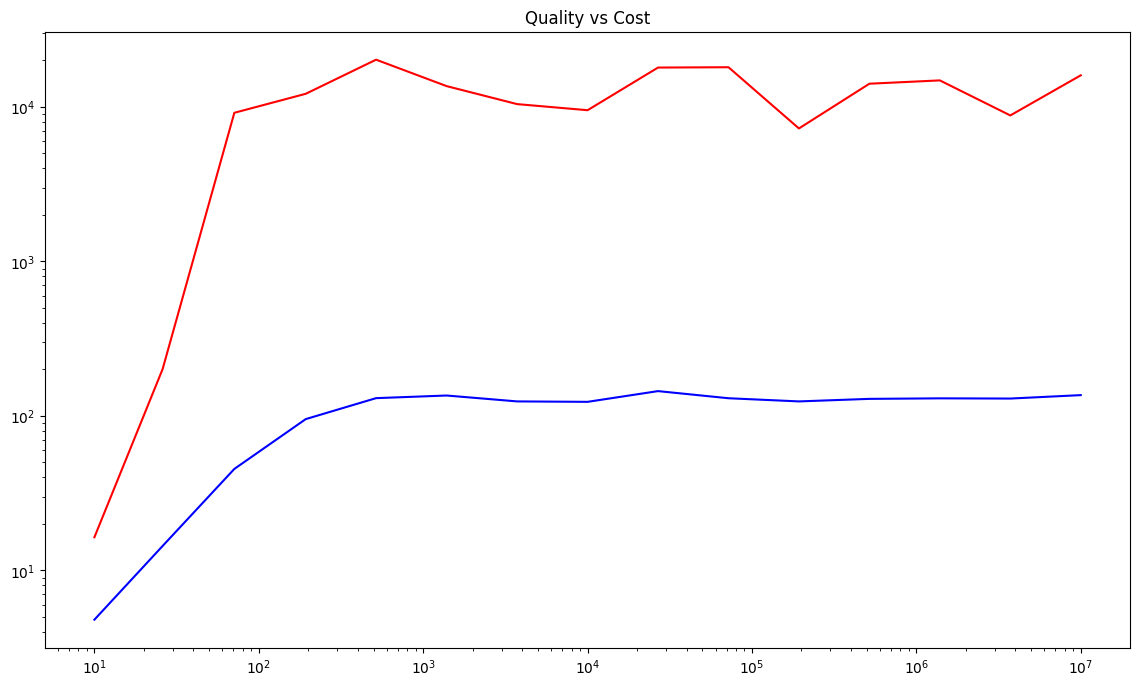

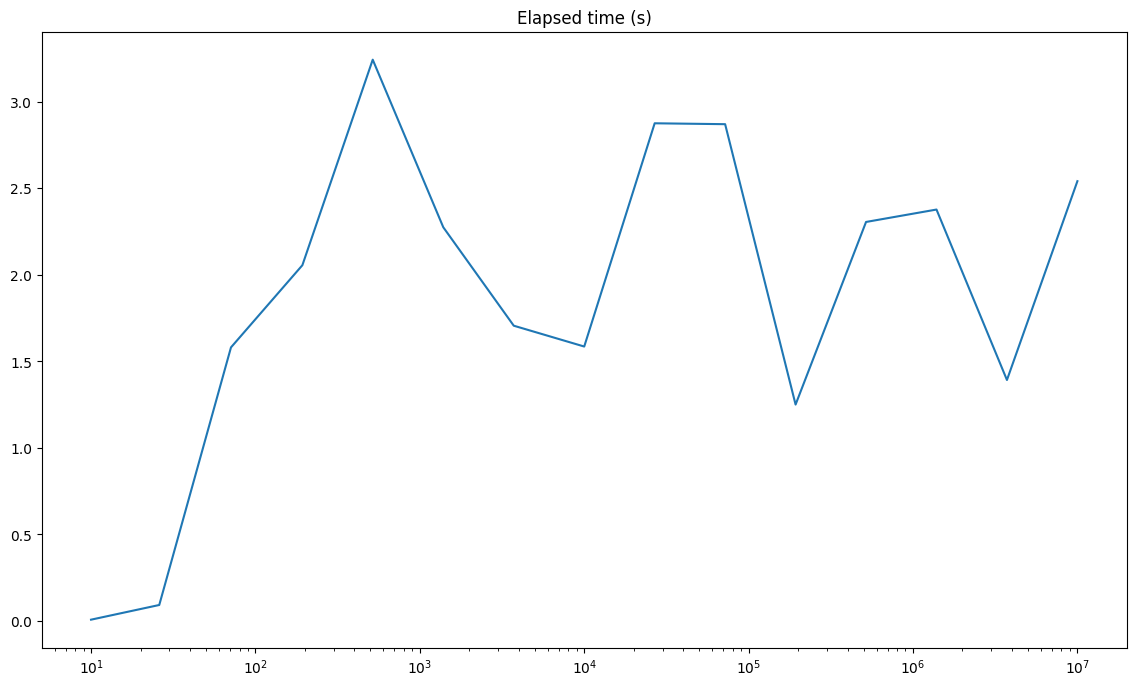

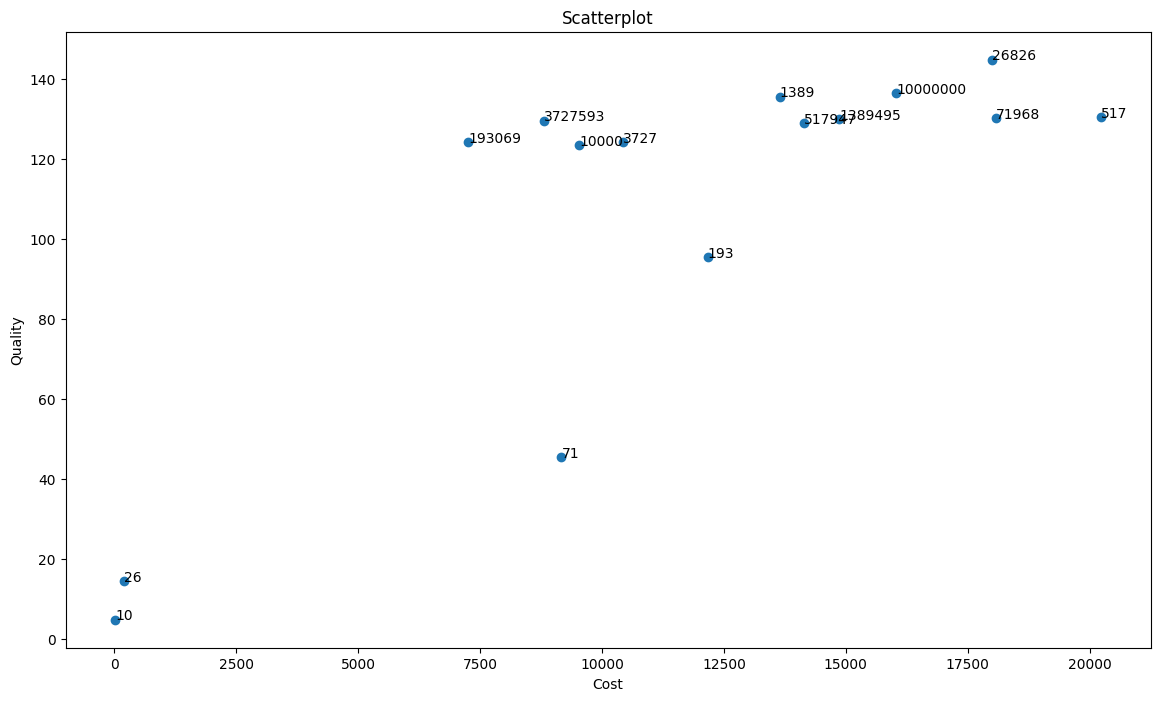

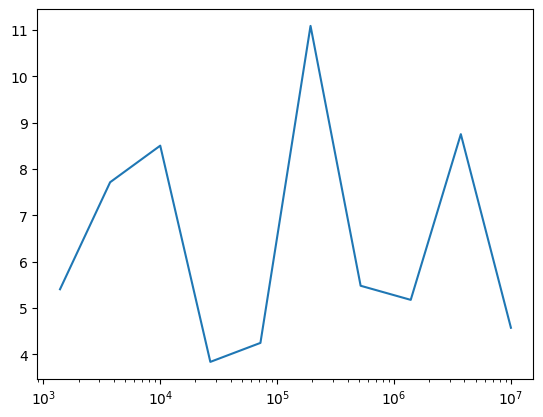

In [ ]:
values = list(map(int, np.logspace(1, 7, num=15).tolist()))
plt.figure("quality", figsize=(14,8))
plt.loglog(values, qualities, color="blue")
plt.title("Quality vs Cost")
plt.semilogx(values, costs, color="red")
plt.figure("elapsed", figsize=(14,8))
plt.semilogx(values, elapseds)
plt.title("Elapsed time (s)")
plt.figure("scatter", figsize=(14,8))
plt.scatter(costs, qualities, )
plt.title("Scatterplot")
plt.xlabel("Cost")
plt.ylabel("Quality")
for (i, (c, q)) in enumerate(zip(costs, qualities)):
    plt.annotate(f"{int(values[i]):2d}", (c,q))

plt.show()



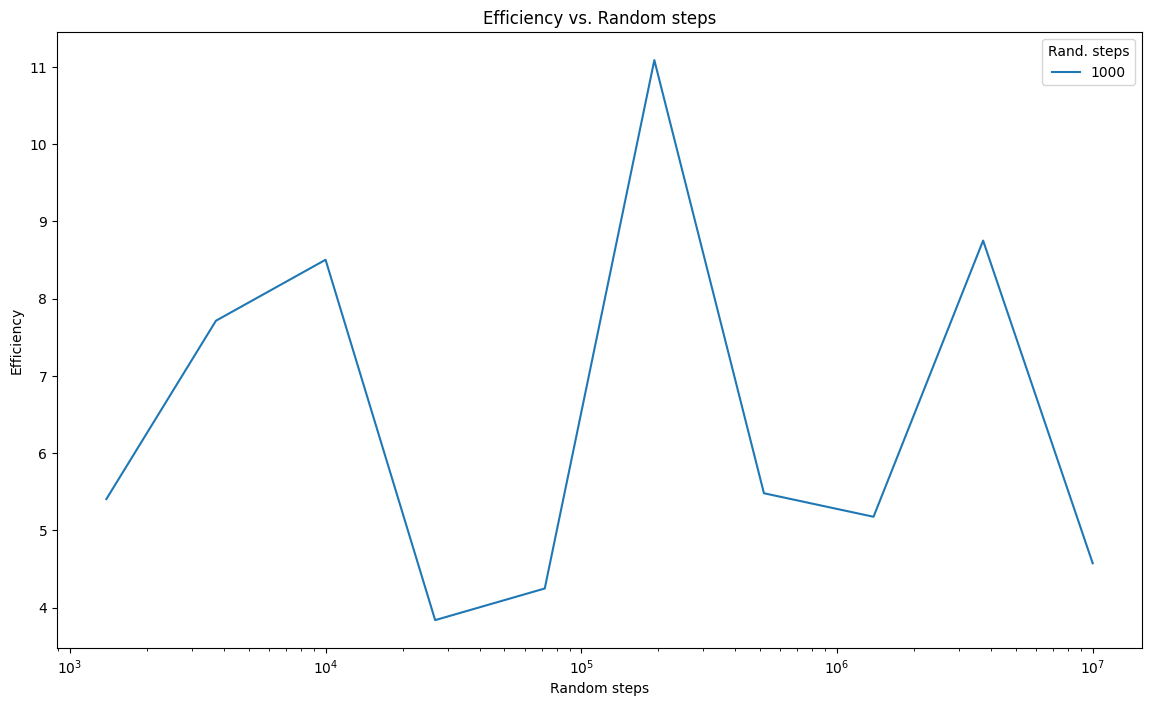

In [119]:
eff = (1e7 / (np.array(qualities[5:]) * np.array(costs[5:]))).tolist()
plt.figure("efficiency", figsize=(14,8))
plt.semilogx(values[5:], eff, label=rand_steps)
plt.title("Efficiency vs. Random steps")
plt.xlabel("Random steps")
plt.ylabel("Efficiency")
plt.legend(title="Rand. steps")
plt.show()

#### Results
For n > 200, the scatter points are always in the same region.
Hence, it is expected the algorithm behave in the same way across different instances, given n greater than some constant N.

To have some safety margin N = 1000 is chosen.

### Fine-grained fixed exponent
Fixed exponent is chosen, since it balances quality vs cost better than others.

**Note**: the second best could be arctan scheduling, with lower quality (25% estimated) but higher cost (3.5x).

The value of the exponent is tweaked around 2, in a small range

In [121]:
results = dict()

fixed_heur = dict(zip([strategies[0]], [functions[0]]))
exp_values = np.linspace(1.5, 2.2, num=8).tolist()[::-1]      # 0.1 step, starting from fastest

rand_steps_values = [1000, 10_000, 30_000, 100_000]         # 1000 original value, others are minimums in the cost plot
for rand_steps in rand_steps_values:
    TRIES = 30
    for i in range(TRIES):
        goal = np.array([n for n in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
        content = init_state(goal, randomize_steps=rand_steps)
        print(f"Instance {i}")
        print(content)
        results[rand_steps] = dict()
        solve_instance(content, goal, results[rand_steps], heuristics=fixed_heur, exp_values=exp_values)

results


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 0
[[ 3  5  2 13]
 [14  1  4  8]
 [ 0  6 12 10]
 [ 7 11  9 15]]
fixed, 2.2: True, 138, 16353, time: 2.41 s
fixed, 2.1: True, 138, 15168, time: 2.31 s
fixed, 2.0: True, 138, 13292, time: 1.88 s
fixed, 1.9000000000000001: True, 138, 12131, time: 1.71 s
fixed, 1.8: True, 108, 14390, time: 2.05 s
fixed, 1.7: True, 104, 12715, time: 1.94 s
fixed, 1.6: True, 98, 13218, time: 1.84 s
fixed, 1.5: True, 92, 6944, time: 0.98 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 1
[[ 9 10  8 13]
 [ 6  2 15  4]
 [12 14  1 11]
 [ 7  0  5  3]]
fixed, 2.2: True, 140, 14785, time: 2.14 s
fixed, 2.1: True, 140, 17861, time: 2.48 s
fixed, 2.0: True, 124, 34754, time: 4.88 s
fixed, 1.9000000000000001: True, 120, 21904, time: 2.99 s
fixed, 1.8: True, 110, 13989, time: 2.06 s
fixed, 1.7: True, 108, 21972, time: 3.14 s
fixed, 1.6: True, 106, 31886, time: 4.07 s
fixed, 1.5: True, 96, 56186, time: 7.43 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 2
[[ 9 13  0  2]
 [12 15  3  6]
 [ 8  7  1 10]
 [14 11  4  5]]
fixed, 2.2: True, 116, 3014, time: 0.48 s
fixed, 2.1: True, 116, 3014, time: 0.44 s
fixed, 2.0: True, 116, 3014, time: 0.44 s
fixed, 1.9000000000000001: True, 116, 2998, time: 0.42 s
fixed, 1.8: True, 116, 2975, time: 0.44 s
fixed, 1.7: True, 112, 3985, time: 0.58 s
fixed, 1.6: True, 112, 3241, time: 0.46 s
fixed, 1.5: True, 106, 33135, time: 4.68 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 3
[[11  3 15  1]
 [12 10  5  4]
 [ 0 13  7  2]
 [ 9 14  6  8]]
fixed, 2.2: True, 100, 4689, time: 0.75 s
fixed, 2.1: True, 100, 4016, time: 0.58 s
fixed, 2.0: True, 100, 3616, time: 0.53 s
fixed, 1.9000000000000001: True, 100, 3413, time: 0.50 s
fixed, 1.8: True, 110, 15346, time: 2.15 s
fixed, 1.7: True, 100, 32652, time: 4.50 s
fixed, 1.6: True, 90, 13161, time: 1.99 s
fixed, 1.5: True, 90, 6401, time: 0.94 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 4
[[ 3 15 14  5]
 [13 11 10 12]
 [ 6  7  0  4]
 [ 2  8  9  1]]
fixed, 2.2: True, 170, 37588, time: 5.47 s
fixed, 2.1: True, 170, 43376, time: 5.86 s
fixed, 2.0: True, 178, 35615, time: 4.93 s
fixed, 1.9000000000000001: True, 174, 32184, time: 4.51 s
fixed, 1.8: True, 166, 48364, time: 6.81 s
fixed, 1.7: True, 158, 23487, time: 3.43 s
fixed, 1.6: True, 128, 32264, time: 4.64 s
fixed, 1.5: True, 126, 3514, time: 0.51 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 5
[[ 4  8 10 12]
 [ 7  9 11 13]
 [ 2  6  1 15]
 [ 3  0 14  5]]
fixed, 2.2: True, 148, 25488, time: 3.68 s
fixed, 2.1: True, 148, 20199, time: 2.93 s
fixed, 2.0: True, 148, 16203, time: 2.31 s
fixed, 1.9000000000000001: True, 152, 20690, time: 2.91 s
fixed, 1.8: True, 146, 13286, time: 2.01 s
fixed, 1.7: True, 136, 21219, time: 3.03 s
fixed, 1.6: True, 122, 12702, time: 1.82 s
fixed, 1.5: True, 122, 20687, time: 3.17 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 6
[[ 5 13  4 11]
 [12  9  3  8]
 [15 14  7  2]
 [ 6  0  1 10]]
fixed, 2.2: True, 196, 18396, time: 2.69 s
fixed, 2.1: True, 166, 52794, time: 7.57 s
fixed, 2.0: True, 146, 49053, time: 6.62 s
fixed, 1.9000000000000001: True, 146, 38149, time: 5.40 s
fixed, 1.8: True, 136, 40345, time: 5.63 s
fixed, 1.7: True, 132, 68210, time: 9.29 s
fixed, 1.6: True, 106, 77642, time: 10.73 s
fixed, 1.5: True, 100, 49672, time: 6.73 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 7
[[11  1  0  7]
 [14  4  9 12]
 [ 5 13  2  6]
 [15  3  8 10]]
fixed, 2.2: True, 114, 3583, time: 0.56 s
fixed, 2.1: True, 114, 3286, time: 0.48 s
fixed, 2.0: True, 114, 2963, time: 0.44 s
fixed, 1.9000000000000001: True, 114, 2730, time: 0.39 s
fixed, 1.8: True, 110, 2267, time: 0.38 s
fixed, 1.7: True, 94, 2217, time: 0.32 s
fixed, 1.6: True, 94, 1649, time: 0.24 s
fixed, 1.5: True, 90, 1493, time: 0.23 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 8
[[11 10  3  7]
 [ 6  1  5  0]
 [ 8 12  4 14]
 [15  9 13  2]]
fixed, 2.2: True, 112, 2062, time: 0.36 s
fixed, 2.1: True, 112, 2076, time: 0.31 s
fixed, 2.0: True, 112, 2128, time: 0.32 s
fixed, 1.9000000000000001: True, 112, 2220, time: 0.32 s
fixed, 1.8: True, 104, 2280, time: 0.34 s
fixed, 1.7: True, 94, 1832, time: 0.27 s
fixed, 1.6: True, 94, 1537, time: 0.23 s
fixed, 1.5: True, 94, 1413, time: 0.21 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 9
[[ 3 11 14  2]
 [10  0 15 12]
 [ 7  5 13  1]
 [ 9  8  4  6]]
fixed, 2.2: True, 188, 14712, time: 2.34 s
fixed, 2.1: True, 188, 14241, time: 2.02 s
fixed, 2.0: True, 176, 22340, time: 3.05 s
fixed, 1.9000000000000001: True, 158, 32321, time: 4.52 s
fixed, 1.8: True, 158, 24476, time: 3.32 s
fixed, 1.7: True, 128, 23033, time: 3.13 s
fixed, 1.6: True, 100, 9012, time: 1.50 s
fixed, 1.5: True, 100, 3268, time: 0.48 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 10
[[15 12  0  2]
 [ 9 11  4  5]
 [ 3 10  8 13]
 [ 6  1  7 14]]
fixed, 2.2: True, 176, 17920, time: 2.57 s
fixed, 2.1: True, 174, 22033, time: 3.06 s
fixed, 2.0: True, 164, 21510, time: 3.11 s
fixed, 1.9000000000000001: True, 164, 18099, time: 2.63 s
fixed, 1.8: True, 138, 8424, time: 1.22 s
fixed, 1.7: True, 136, 7671, time: 1.14 s
fixed, 1.6: True, 136, 17803, time: 2.55 s
fixed, 1.5: True, 110, 7631, time: 1.26 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 11
[[12  7 13  3]
 [ 5  0 14 15]
 [ 6 10  2 11]
 [ 4  9  1  8]]
fixed, 2.2: True, 140, 24053, time: 3.57 s
fixed, 2.1: True, 140, 26578, time: 3.86 s
fixed, 2.0: True, 140, 28899, time: 4.53 s
fixed, 1.9000000000000001: True, 140, 26599, time: 4.24 s
fixed, 1.8: True, 144, 21806, time: 3.15 s
fixed, 1.7: True, 126, 16739, time: 2.33 s
fixed, 1.6: True, 120, 28638, time: 3.90 s
fixed, 1.5: True, 120, 19918, time: 2.90 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 12
[[ 4 15  0  5]
 [ 9  6 11  3]
 [ 7 14 10 13]
 [ 1  8 12  2]]
fixed, 2.2: True, 176, 18644, time: 2.74 s
fixed, 2.1: True, 176, 17768, time: 2.50 s
fixed, 2.0: True, 176, 20841, time: 2.93 s
fixed, 1.9000000000000001: True, 132, 10882, time: 1.68 s
fixed, 1.8: True, 130, 11288, time: 1.62 s
fixed, 1.7: True, 116, 23227, time: 3.19 s
fixed, 1.6: True, 116, 10330, time: 1.49 s
fixed, 1.5: True, 96, 5059, time: 0.75 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 13
[[14 12 11  7]
 [15  0  6 10]
 [ 4  9  5  8]
 [ 1 13  2  3]]
fixed, 2.2: True, 152, 11808, time: 1.83 s
fixed, 2.1: True, 152, 14224, time: 1.96 s
fixed, 2.0: True, 142, 13624, time: 1.88 s
fixed, 1.9000000000000001: True, 142, 10511, time: 1.51 s
fixed, 1.8: True, 142, 11052, time: 1.56 s
fixed, 1.7: True, 124, 11780, time: 1.88 s
fixed, 1.6: True, 116, 13780, time: 1.96 s
fixed, 1.5: True, 96, 8740, time: 1.24 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 14
[[14  5  2  8]
 [12  3 10 11]
 [ 4 15  6  1]
 [13  9  7  0]]
fixed, 2.2: True, 92, 12721, time: 1.91 s
fixed, 2.1: True, 92, 12625, time: 1.79 s
fixed, 2.0: True, 92, 11770, time: 1.71 s
fixed, 1.9000000000000001: True, 92, 10141, time: 1.56 s
fixed, 1.8: True, 92, 8242, time: 1.19 s
fixed, 1.7: True, 92, 6251, time: 0.88 s
fixed, 1.6: True, 92, 7799, time: 1.12 s
fixed, 1.5: True, 92, 6253, time: 0.91 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 15
[[ 9  8 15  3]
 [ 7  0  4 12]
 [14 10  6  2]
 [ 1  5 13 11]]
fixed, 2.2: True, 122, 7351, time: 1.06 s
fixed, 2.1: True, 122, 6742, time: 0.99 s
fixed, 2.0: True, 122, 5888, time: 0.84 s
fixed, 1.9000000000000001: True, 126, 6596, time: 0.93 s
fixed, 1.8: True, 126, 5987, time: 0.86 s
fixed, 1.7: True, 108, 17593, time: 2.60 s
fixed, 1.6: True, 98, 19630, time: 2.76 s
fixed, 1.5: True, 92, 37996, time: 5.39 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 16
[[13  6 10  4]
 [ 9 11 12  5]
 [ 2  7  0 14]
 [15  3  1  8]]
fixed, 2.2: True, 194, 25527, time: 3.71 s
fixed, 2.1: True, 194, 23451, time: 3.34 s
fixed, 2.0: True, 194, 21514, time: 3.23 s
fixed, 1.9000000000000001: True, 194, 23541, time: 3.32 s
fixed, 1.8: True, 164, 81565, time: 11.39 s
fixed, 1.7: True, 156, 39563, time: 5.64 s
fixed, 1.6: True, 122, 12521, time: 1.78 s
fixed, 1.5: True, 120, 10623, time: 1.61 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 17
[[ 1  8 11  7]
 [ 6  9 12 10]
 [13  2 14  5]
 [15  4  3  0]]
fixed, 2.2: True, 132, 4471, time: 0.82 s
fixed, 2.1: True, 132, 4459, time: 0.66 s
fixed, 2.0: True, 122, 4546, time: 0.67 s
fixed, 1.9000000000000001: True, 122, 8019, time: 1.14 s
fixed, 1.8: True, 118, 8639, time: 1.24 s
fixed, 1.7: True, 114, 7923, time: 1.15 s
fixed, 1.6: True, 104, 6120, time: 0.91 s
fixed, 1.5: True, 92, 15285, time: 2.16 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 18
[[14 15  4 11]
 [ 9  0  8 13]
 [ 5  2  1  6]
 [12 10  7  3]]
fixed, 2.2: True, 156, 11329, time: 1.78 s
fixed, 2.1: True, 156, 10791, time: 1.53 s
fixed, 2.0: True, 156, 9912, time: 1.46 s
fixed, 1.9000000000000001: True, 158, 11783, time: 1.69 s
fixed, 1.8: True, 124, 17509, time: 2.47 s
fixed, 1.7: True, 130, 47201, time: 6.41 s
fixed, 1.6: True, 104, 37012, time: 5.01 s
fixed, 1.5: True, 100, 7409, time: 1.09 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 19
[[ 4 13  9 14]
 [ 2  3  6 11]
 [ 7 10  5 12]
 [15  1  8  0]]
fixed, 2.2: True, 148, 22213, time: 3.14 s
fixed, 2.1: True, 148, 21653, time: 3.05 s
fixed, 2.0: True, 148, 20388, time: 2.96 s
fixed, 1.9000000000000001: True, 134, 23165, time: 3.16 s
fixed, 1.8: True, 124, 29673, time: 4.06 s
fixed, 1.7: True, 106, 32778, time: 4.52 s
fixed, 1.6: True, 106, 13619, time: 1.95 s
fixed, 1.5: True, 102, 19499, time: 2.93 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 20
[[12  6 11  4]
 [ 8 14 15  5]
 [ 1  7  3  9]
 [10  0 13  2]]
fixed, 2.2: True, 136, 18201, time: 2.54 s
fixed, 2.1: True, 136, 13975, time: 1.96 s
fixed, 2.0: True, 136, 11403, time: 1.62 s
fixed, 1.9000000000000001: True, 136, 9980, time: 1.45 s
fixed, 1.8: True, 126, 8970, time: 1.24 s
fixed, 1.7: True, 126, 9681, time: 1.50 s
fixed, 1.6: True, 118, 58996, time: 8.02 s
fixed, 1.5: True, 106, 11469, time: 1.61 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 21
[[ 0 15  8  9]
 [ 2 13  3  7]
 [12  6  5 10]
 [ 1 14 11  4]]
fixed, 2.2: True, 178, 30278, time: 4.27 s
fixed, 2.1: True, 156, 29197, time: 4.13 s
fixed, 2.0: True, 130, 21527, time: 2.95 s
fixed, 1.9000000000000001: True, 130, 11731, time: 1.63 s
fixed, 1.8: True, 120, 16267, time: 2.29 s
fixed, 1.7: True, 118, 13120, time: 1.88 s
fixed, 1.6: True, 110, 7122, time: 1.15 s
fixed, 1.5: True, 108, 22499, time: 3.25 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 22
[[ 4 11 14  1]
 [13  3  5  7]
 [ 0  8 15 12]
 [10  9  6  2]]
fixed, 2.2: True, 130, 4670, time: 0.71 s
fixed, 2.1: True, 130, 4670, time: 0.68 s
fixed, 2.0: True, 122, 9193, time: 1.33 s
fixed, 1.9000000000000001: True, 122, 8836, time: 1.27 s
fixed, 1.8: True, 122, 10529, time: 1.50 s
fixed, 1.7: True, 124, 14747, time: 2.24 s
fixed, 1.6: True, 112, 8138, time: 1.14 s
fixed, 1.5: True, 84, 4089, time: 0.58 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 23
[[ 5  8 11 14]
 [15  7  2  9]
 [ 0 13  4  3]
 [12  6  1 10]]
fixed, 2.2: True, 150, 12423, time: 1.87 s
fixed, 2.1: True, 150, 11049, time: 1.54 s
fixed, 2.0: True, 150, 9321, time: 1.34 s
fixed, 1.9000000000000001: True, 150, 8364, time: 1.19 s
fixed, 1.8: True, 148, 8311, time: 1.40 s
fixed, 1.7: True, 140, 27935, time: 3.86 s
fixed, 1.6: True, 120, 31880, time: 4.44 s
fixed, 1.5: True, 104, 48476, time: 6.83 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 24
[[ 5  4  0 12]
 [ 7 15 11  8]
 [ 6  1 10 13]
 [ 2 14  9  3]]
fixed, 2.2: True, 128, 28901, time: 4.11 s
fixed, 2.1: True, 128, 33249, time: 4.37 s
fixed, 2.0: True, 136, 27251, time: 3.84 s
fixed, 1.9000000000000001: True, 132, 27765, time: 3.77 s
fixed, 1.8: True, 122, 37963, time: 5.14 s
fixed, 1.7: True, 114, 66027, time: 8.75 s
fixed, 1.6: True, 110, 106278, time: 14.11 s
fixed, 1.5: True, 96, 21341, time: 3.21 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 25
[[14 11  6  2]
 [ 8  7 12  1]
 [ 0 13 15  4]
 [ 5  9  3 10]]
fixed, 2.2: True, 138, 31247, time: 4.46 s
fixed, 2.1: True, 116, 31854, time: 4.66 s
fixed, 2.0: True, 116, 25428, time: 3.50 s
fixed, 1.9000000000000001: True, 116, 22093, time: 3.02 s
fixed, 1.8: True, 116, 18855, time: 2.67 s
fixed, 1.7: True, 120, 29043, time: 4.15 s
fixed, 1.6: True, 114, 20904, time: 6.69 s
fixed, 1.5: True, 108, 6102, time: 1.96 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 26
[[ 5  4 10  3]
 [ 9 14  8  0]
 [ 6 12  1 13]
 [ 2 11 15  7]]
fixed, 2.2: True, 114, 3063, time: 0.79 s
fixed, 2.1: True, 114, 3066, time: 0.69 s
fixed, 2.0: True, 114, 3121, time: 0.66 s
fixed, 1.9000000000000001: True, 114, 4445, time: 0.97 s
fixed, 1.8: True, 114, 4567, time: 1.06 s
fixed, 1.7: True, 110, 6421, time: 1.43 s
fixed, 1.6: True, 110, 8434, time: 1.88 s
fixed, 1.5: True, 84, 11794, time: 2.37 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 27
[[ 4 12 10  6]
 [15  2  7 14]
 [ 3  1 11  9]
 [13  0  5  8]]
fixed, 2.2: True, 128, 16475, time: 3.59 s
fixed, 2.1: True, 128, 16881, time: 3.71 s
fixed, 2.0: True, 124, 15601, time: 3.25 s
fixed, 1.9000000000000001: True, 122, 13309, time: 2.77 s
fixed, 1.8: True, 122, 13745, time: 2.64 s
fixed, 1.7: True, 122, 15650, time: 2.71 s
fixed, 1.6: True, 112, 40959, time: 7.81 s
fixed, 1.5: True, 100, 11179, time: 2.40 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 28
[[ 5 15  2 12]
 [ 9 11 10  6]
 [ 1 14  8  7]
 [13  4  3  0]]
fixed, 2.2: True, 122, 12566, time: 2.45 s
fixed, 2.1: True, 122, 11758, time: 2.42 s
fixed, 2.0: True, 106, 15028, time: 3.27 s
fixed, 1.9000000000000001: True, 108, 13740, time: 3.60 s
fixed, 1.8: True, 108, 10159, time: 2.44 s
fixed, 1.7: True, 98, 15468, time: 3.91 s
fixed, 1.6: True, 98, 4802, time: 1.17 s
fixed, 1.5: True, 64, 2889, time: 0.71 s


Randomizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Instance 29
[[10  6  0 14]
 [ 8  9  1  2]
 [13 15 12 11]
 [ 7  4  5  3]]
fixed, 2.2: True, 164, 42929, time: 10.55 s
fixed, 2.1: True, 120, 44173, time: 10.39 s
fixed, 2.0: True, 118, 25742, time: 4.62 s
fixed, 1.9000000000000001: True, 118, 13848, time: 3.84 s
fixed, 1.8: True, 118, 7795, time: 2.30 s
fixed, 1.7: True, 118, 21418, time: 5.33 s
fixed, 1.6: True, 106, 45388, time: 10.95 s
fixed, 1.5: True, 100, 18270, time: 4.37 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 0
[[ 3  1  0  2]
 [14  7  4  5]
 [10  8 13 15]
 [ 9 12 11  6]]
fixed, 2.2: True, 120, 5590, time: 1.26 s
fixed, 2.1: True, 120, 5587, time: 1.23 s
fixed, 2.0: True, 120, 5468, time: 1.38 s
fixed, 1.9000000000000001: True, 120, 5305, time: 1.30 s
fixed, 1.8: True, 122, 14801, time: 3.84 s
fixed, 1.7: True, 122, 8967, time: 2.80 s
fixed, 1.6: True, 96, 24841, time: 5.95 s
fixed, 1.5: True, 78, 4825, time: 1.20 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 1
[[ 8 15  0 10]
 [14  7  3  4]
 [13 12  5  6]
 [ 1  9  2 11]]
fixed, 2.2: True, 124, 42472, time: 9.82 s
fixed, 2.1: True, 124, 35082, time: 7.37 s
fixed, 2.0: True, 124, 27456, time: 5.97 s
fixed, 1.9000000000000001: True, 124, 23839, time: 4.85 s
fixed, 1.8: True, 124, 21497, time: 4.08 s
fixed, 1.7: True, 116, 37366, time: 7.89 s
fixed, 1.6: True, 114, 37418, time: 7.64 s
fixed, 1.5: True, 114, 29347, time: 6.32 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 2
[[ 5  1 11  9]
 [ 8 15  2  7]
 [ 3 10  0  4]
 [14 13 12  6]]
fixed, 2.2: True, 122, 6022, time: 1.34 s
fixed, 2.1: True, 122, 5794, time: 1.29 s
fixed, 2.0: True, 122, 5508, time: 1.14 s
fixed, 1.9000000000000001: True, 122, 5333, time: 1.15 s
fixed, 1.8: True, 122, 4950, time: 1.03 s
fixed, 1.7: True, 116, 4231, time: 1.06 s
fixed, 1.6: True, 114, 5921, time: 1.28 s
fixed, 1.5: True, 102, 6800, time: 1.50 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 3
[[ 4 14  1  6]
 [15 10  5  0]
 [ 9  8 12 11]
 [13  7  3  2]]
fixed, 2.2: True, 160, 12387, time: 2.82 s
fixed, 2.1: True, 160, 11582, time: 2.41 s
fixed, 2.0: True, 158, 11040, time: 2.30 s
fixed, 1.9000000000000001: True, 158, 10410, time: 2.23 s
fixed, 1.8: True, 146, 17578, time: 3.81 s
fixed, 1.7: True, 142, 19269, time: 4.21 s
fixed, 1.6: True, 136, 48840, time: 10.02 s
fixed, 1.5: True, 106, 40251, time: 8.61 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 4
[[11  6  9  2]
 [14  4 12 10]
 [ 7 15  5 13]
 [ 1  3  8  0]]
fixed, 2.2: True, 134, 9153, time: 2.06 s
fixed, 2.1: True, 134, 7846, time: 1.73 s
fixed, 2.0: True, 134, 7226, time: 1.65 s
fixed, 1.9000000000000001: True, 134, 7671, time: 1.81 s
fixed, 1.8: True, 138, 12948, time: 2.84 s
fixed, 1.7: True, 138, 20270, time: 4.27 s
fixed, 1.6: True, 128, 61868, time: 12.80 s
fixed, 1.5: True, 118, 27992, time: 5.95 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 5
[[ 7 11  5  9]
 [10 14 13 15]
 [ 0  4  1  3]
 [ 6 12  8  2]]
fixed, 2.2: True, 130, 2451, time: 0.57 s
fixed, 2.1: True, 130, 2390, time: 0.57 s
fixed, 2.0: True, 130, 2045, time: 0.51 s
fixed, 1.9000000000000001: True, 130, 2012, time: 0.42 s
fixed, 1.8: True, 130, 1975, time: 0.41 s
fixed, 1.7: True, 130, 1851, time: 0.43 s
fixed, 1.6: True, 130, 2360, time: 0.53 s
fixed, 1.5: True, 120, 3474, time: 0.80 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 6
[[14  8  7  2]
 [15  3 10  4]
 [ 0 11 12  1]
 [ 5 13  9  6]]
fixed, 2.2: True, 170, 7933, time: 1.82 s
fixed, 2.1: True, 148, 7745, time: 1.63 s
fixed, 2.0: True, 148, 9498, time: 2.13 s
fixed, 1.9000000000000001: True, 148, 9033, time: 1.97 s
fixed, 1.8: True, 142, 7448, time: 1.54 s
fixed, 1.7: True, 124, 11932, time: 2.31 s
fixed, 1.6: True, 112, 25733, time: 4.61 s
fixed, 1.5: True, 90, 19583, time: 3.25 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 7
[[15  5 13  9]
 [ 6  7  8 14]
 [ 4  1  0  3]
 [12  2 11 10]]
fixed, 2.2: True, 112, 5433, time: 1.09 s
fixed, 2.1: True, 112, 5149, time: 0.93 s
fixed, 2.0: True, 112, 4774, time: 0.87 s
fixed, 1.9000000000000001: True, 112, 4606, time: 0.84 s
fixed, 1.8: True, 112, 4749, time: 0.87 s
fixed, 1.7: True, 108, 7825, time: 1.37 s
fixed, 1.6: True, 104, 3745, time: 0.77 s
fixed, 1.5: True, 104, 2937, time: 0.52 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 8
[[11 10  9  8]
 [ 4 14 13 12]
 [ 6  2  0  3]
 [15  7  1  5]]
fixed, 2.2: True, 194, 7747, time: 1.38 s
fixed, 2.1: True, 194, 7750, time: 1.38 s
fixed, 2.0: True, 166, 9614, time: 1.62 s
fixed, 1.9000000000000001: True, 166, 9822, time: 1.75 s
fixed, 1.8: True, 130, 7261, time: 1.30 s
fixed, 1.7: True, 104, 1659, time: 0.28 s
fixed, 1.6: True, 104, 1561, time: 0.29 s
fixed, 1.5: True, 104, 1609, time: 0.30 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 9
[[ 0  5  3 14]
 [ 1  7  4  6]
 [ 9  2  8 12]
 [13 10 15 11]]
fixed, 2.2: True, 74, 20906, time: 3.96 s
fixed, 2.1: True, 74, 25379, time: 4.31 s
fixed, 2.0: True, 74, 30541, time: 5.05 s
fixed, 1.9000000000000001: True, 74, 43512, time: 7.46 s
fixed, 1.8: True, 62, 43685, time: 7.69 s
fixed, 1.7: True, 58, 42125, time: 7.19 s
fixed, 1.6: True, 58, 31716, time: 5.59 s
fixed, 1.5: True, 62, 52640, time: 9.20 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 10
[[15  8  0  5]
 [12 11  7  4]
 [ 3 14 10  6]
 [ 9  1 13  2]]
fixed, 2.2: True, 148, 6129, time: 1.18 s
fixed, 2.1: True, 148, 5778, time: 1.01 s
fixed, 2.0: True, 148, 5446, time: 0.93 s
fixed, 1.9000000000000001: True, 134, 4814, time: 0.86 s
fixed, 1.8: True, 134, 4467, time: 0.81 s
fixed, 1.7: True, 134, 21158, time: 3.74 s
fixed, 1.6: True, 126, 21900, time: 4.04 s
fixed, 1.5: True, 112, 26927, time: 4.84 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 11
[[ 2  6  1  3]
 [12 14  4  8]
 [11  5  9 10]
 [13 15  7  0]]
fixed, 2.2: True, 112, 10210, time: 2.07 s
fixed, 2.1: True, 112, 9584, time: 1.79 s
fixed, 2.0: True, 112, 8812, time: 1.64 s
fixed, 1.9000000000000001: True, 116, 9333, time: 1.83 s
fixed, 1.8: True, 116, 10467, time: 1.93 s
fixed, 1.7: True, 112, 14563, time: 2.79 s
fixed, 1.6: True, 102, 43692, time: 7.72 s
fixed, 1.5: True, 76, 40959, time: 6.85 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 12
[[ 5  7 10  3]
 [ 8 12 14  4]
 [13  1  0  9]
 [ 2 15 11  6]]
fixed, 2.2: True, 126, 35161, time: 6.19 s
fixed, 2.1: True, 126, 33707, time: 5.81 s
fixed, 2.0: True, 126, 49248, time: 8.33 s
fixed, 1.9000000000000001: True, 126, 47939, time: 7.54 s
fixed, 1.8: True, 116, 37663, time: 6.18 s
fixed, 1.7: True, 108, 36753, time: 6.24 s
fixed, 1.6: True, 104, 12079, time: 2.03 s
fixed, 1.5: True, 100, 16590, time: 3.17 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 13
[[ 9 11  7  2]
 [ 8 10 12 14]
 [ 1 15  0  6]
 [ 3  5 13  4]]
fixed, 2.2: True, 104, 1866, time: 0.43 s
fixed, 2.1: True, 104, 1866, time: 0.40 s
fixed, 2.0: True, 104, 1862, time: 0.40 s
fixed, 1.9000000000000001: True, 104, 2427, time: 0.50 s
fixed, 1.8: True, 96, 3351, time: 0.63 s
fixed, 1.7: True, 96, 2327, time: 0.46 s
fixed, 1.6: True, 84, 3883, time: 0.73 s
fixed, 1.5: True, 80, 2684, time: 0.50 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 14
[[12 14  1 10]
 [13  8  5  2]
 [ 7 11  0  9]
 [ 6 15  3  4]]
fixed, 2.2: True, 144, 11504, time: 2.33 s
fixed, 2.1: True, 144, 21946, time: 4.12 s
fixed, 2.0: True, 144, 23921, time: 4.03 s
fixed, 1.9000000000000001: True, 126, 20280, time: 3.34 s
fixed, 1.8: True, 122, 19059, time: 3.37 s
fixed, 1.7: True, 122, 17917, time: 2.95 s
fixed, 1.6: True, 110, 26848, time: 5.22 s
fixed, 1.5: True, 102, 23952, time: 5.05 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 15
[[ 1 13  6  4]
 [ 5  8  7 15]
 [ 0  3 12 11]
 [14  2 10  9]]
fixed, 2.2: True, 144, 13056, time: 2.72 s
fixed, 2.1: True, 144, 17656, time: 3.76 s
fixed, 2.0: True, 128, 30750, time: 6.28 s
fixed, 1.9000000000000001: True, 130, 33212, time: 5.70 s
fixed, 1.8: True, 108, 3394, time: 0.62 s
fixed, 1.7: True, 100, 6433, time: 1.14 s
fixed, 1.6: True, 98, 9352, time: 1.47 s
fixed, 1.5: True, 68, 1470, time: 0.25 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 16
[[14  6 10 13]
 [ 5  0  9 11]
 [15  2  4 12]
 [ 1  7  8  3]]
fixed, 2.2: True, 142, 18783, time: 3.79 s
fixed, 2.1: True, 142, 19442, time: 3.64 s
fixed, 2.0: True, 142, 23315, time: 4.16 s
fixed, 1.9000000000000001: True, 142, 29304, time: 5.00 s
fixed, 1.8: True, 138, 29045, time: 4.79 s
fixed, 1.7: True, 130, 9164, time: 1.51 s
fixed, 1.6: True, 106, 9314, time: 1.61 s
fixed, 1.5: True, 108, 8555, time: 1.60 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 17
[[14 12  8  4]
 [13  0 10  1]
 [ 2  7  6 11]
 [15  9  5  3]]
fixed, 2.2: True, 174, 7829, time: 1.34 s
fixed, 2.1: True, 156, 8596, time: 1.57 s
fixed, 2.0: True, 174, 38710, time: 6.09 s
fixed, 1.9000000000000001: True, 138, 32652, time: 5.39 s
fixed, 1.8: True, 138, 16849, time: 2.73 s
fixed, 1.7: True, 138, 9693, time: 1.53 s
fixed, 1.6: True, 118, 4260, time: 0.85 s
fixed, 1.5: True, 104, 3748, time: 0.67 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 18
[[11  2  8  1]
 [14 10  6 12]
 [15  3  0  4]
 [13  7  9  5]]
fixed, 2.2: True, 176, 5153, time: 1.00 s
fixed, 2.1: True, 176, 5084, time: 1.03 s
fixed, 2.0: True, 162, 4853, time: 0.87 s
fixed, 1.9000000000000001: True, 162, 4624, time: 0.81 s
fixed, 1.8: True, 140, 13740, time: 2.35 s
fixed, 1.7: True, 140, 20038, time: 3.47 s
fixed, 1.6: True, 120, 1870, time: 0.37 s
fixed, 1.5: True, 112, 15582, time: 2.69 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 19
[[10  4  2 11]
 [15  1  5  8]
 [12 13  0  6]
 [ 9 14  3  7]]
fixed, 2.2: True, 102, 3295, time: 0.76 s
fixed, 2.1: True, 102, 3230, time: 0.60 s
fixed, 2.0: True, 86, 3166, time: 0.58 s
fixed, 1.9000000000000001: True, 76, 1458, time: 0.27 s
fixed, 1.8: True, 76, 1331, time: 0.24 s
fixed, 1.7: True, 76, 1127, time: 0.22 s
fixed, 1.6: True, 76, 1373, time: 0.25 s
fixed, 1.5: True, 72, 2575, time: 0.47 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 20
[[11  9  4 13]
 [ 1  0  6 10]
 [ 2 14  7 15]
 [12  3  5  8]]
fixed, 2.2: True, 196, 25450, time: 4.36 s
fixed, 2.1: True, 196, 33834, time: 5.72 s
fixed, 2.0: True, 176, 38937, time: 6.34 s
fixed, 1.9000000000000001: True, 146, 23861, time: 3.67 s
fixed, 1.8: True, 146, 13123, time: 2.13 s
fixed, 1.7: True, 134, 5748, time: 0.93 s
fixed, 1.6: True, 138, 18939, time: 2.90 s
fixed, 1.5: True, 112, 6078, time: 0.99 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 21
[[12 15 11  6]
 [ 2  0  3 14]
 [ 8  9  5 10]
 [ 4  7  1 13]]
fixed, 2.2: True, 150, 19345, time: 3.17 s
fixed, 2.1: True, 144, 29762, time: 4.55 s
fixed, 2.0: True, 140, 36584, time: 5.33 s
fixed, 1.9000000000000001: True, 140, 34498, time: 4.77 s
fixed, 1.8: True, 132, 39824, time: 5.62 s
fixed, 1.7: True, 122, 33307, time: 4.49 s
fixed, 1.6: True, 122, 51889, time: 7.25 s
fixed, 1.5: True, 112, 54067, time: 7.67 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 22
[[ 8  1 14 13]
 [ 7  0  5 10]
 [ 6  4 11 15]
 [ 3  9 12  2]]
fixed, 2.2: True, 134, 3383, time: 0.58 s
fixed, 2.1: True, 134, 3387, time: 0.48 s
fixed, 2.0: True, 134, 4831, time: 0.74 s
fixed, 1.9000000000000001: True, 134, 5123, time: 0.75 s
fixed, 1.8: True, 134, 5182, time: 0.79 s
fixed, 1.7: True, 130, 5321, time: 0.79 s
fixed, 1.6: True, 130, 6271, time: 0.91 s
fixed, 1.5: True, 122, 11356, time: 1.65 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 23
[[ 5  8  2  7]
 [ 1  0 10 13]
 [15  3  9 11]
 [ 6 12  4 14]]
fixed, 2.2: True, 154, 31099, time: 4.60 s
fixed, 2.1: True, 154, 36856, time: 4.91 s
fixed, 2.0: True, 162, 28993, time: 4.02 s
fixed, 1.9000000000000001: True, 158, 26085, time: 3.55 s
fixed, 1.8: True, 150, 35110, time: 5.21 s
fixed, 1.7: True, 110, 27601, time: 3.98 s
fixed, 1.6: True, 94, 17396, time: 2.53 s
fixed, 1.5: True, 104, 35525, time: 5.05 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 24
[[ 2  7 12  9]
 [ 1  0  3 13]
 [ 6 15 11  5]
 [10 14  4  8]]
fixed, 2.2: True, 132, 7622, time: 1.12 s
fixed, 2.1: True, 132, 7309, time: 1.05 s
fixed, 2.0: True, 132, 6551, time: 1.08 s
fixed, 1.9000000000000001: True, 132, 6767, time: 0.96 s
fixed, 1.8: True, 128, 22735, time: 3.21 s
fixed, 1.7: True, 116, 25946, time: 3.70 s
fixed, 1.6: True, 98, 28352, time: 4.06 s
fixed, 1.5: True, 82, 69497, time: 9.79 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 25
[[14 12  9  5]
 [ 1 15  6  2]
 [13 10  3  4]
 [ 7  0  8 11]]
fixed, 2.2: True, 160, 24598, time: 3.71 s
fixed, 2.1: True, 160, 23680, time: 3.34 s
fixed, 2.0: True, 160, 22464, time: 3.29 s
fixed, 1.9000000000000001: True, 160, 25400, time: 3.54 s
fixed, 1.8: True, 136, 18605, time: 2.59 s
fixed, 1.7: True, 130, 35376, time: 5.11 s
fixed, 1.6: True, 104, 20541, time: 2.86 s
fixed, 1.5: True, 96, 6185, time: 0.86 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 26
[[14  4  2  5]
 [ 1  8  3 13]
 [ 0  6 10 15]
 [12  9 11  7]]
fixed, 2.2: True, 128, 3338, time: 0.50 s
fixed, 2.1: True, 128, 3943, time: 0.66 s
fixed, 2.0: True, 128, 4056, time: 0.66 s
fixed, 1.9000000000000001: True, 128, 5345, time: 0.78 s
fixed, 1.8: True, 112, 6823, time: 1.00 s
fixed, 1.7: True, 100, 2560, time: 0.38 s
fixed, 1.6: True, 90, 3627, time: 0.65 s
fixed, 1.5: True, 90, 1843, time: 0.26 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 27
[[14  1  9  2]
 [ 3  4 12  7]
 [ 0  6  8 10]
 [ 5 11 13 15]]
fixed, 2.2: True, 152, 36108, time: 5.10 s
fixed, 2.1: True, 138, 30373, time: 4.39 s
fixed, 2.0: True, 138, 25454, time: 3.54 s
fixed, 1.9000000000000001: True, 124, 27157, time: 3.84 s
fixed, 1.8: True, 120, 50702, time: 7.12 s
fixed, 1.7: True, 98, 18900, time: 2.82 s
fixed, 1.6: True, 98, 15197, time: 2.20 s
fixed, 1.5: True, 88, 26173, time: 3.64 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 28
[[10 12  7  2]
 [ 3 15 14  4]
 [ 8  6  9  5]
 [ 1  0 13 11]]
fixed, 2.2: True, 116, 4167, time: 0.62 s
fixed, 2.1: True, 116, 3991, time: 0.59 s
fixed, 2.0: True, 116, 3865, time: 0.56 s
fixed, 1.9000000000000001: True, 116, 3696, time: 0.56 s
fixed, 1.8: True, 116, 3365, time: 0.50 s
fixed, 1.7: True, 112, 6305, time: 0.89 s
fixed, 1.6: True, 104, 15292, time: 2.30 s
fixed, 1.5: True, 92, 3437, time: 0.50 s


Randomizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Instance 29
[[ 0  2 13  4]
 [ 9  6  1 14]
 [10  5 12  3]
 [15  7 11  8]]
fixed, 2.2: True, 136, 21359, time: 3.00 s
fixed, 2.1: True, 120, 17199, time: 2.36 s
fixed, 2.0: True, 120, 17372, time: 2.55 s
fixed, 1.9000000000000001: True, 120, 20178, time: 2.79 s
fixed, 1.8: True, 112, 29233, time: 4.04 s
fixed, 1.7: True, 104, 19830, time: 2.94 s
fixed, 1.6: True, 92, 27883, time: 3.91 s
fixed, 1.5: True, 80, 45860, time: 6.19 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 0
[[ 5  6 11  7]
 [14  0  2 13]
 [ 9  3  8 10]
 [15  1 12  4]]
fixed, 2.2: True, 108, 5778, time: 0.85 s
fixed, 2.1: True, 108, 5578, time: 0.79 s
fixed, 2.0: True, 98, 4848, time: 0.68 s
fixed, 1.9000000000000001: True, 98, 4177, time: 0.61 s
fixed, 1.8: True, 98, 4031, time: 0.57 s
fixed, 1.7: True, 84, 6509, time: 0.93 s
fixed, 1.6: True, 84, 3057, time: 0.45 s
fixed, 1.5: True, 84, 9723, time: 1.38 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 1
[[ 3 11  7  2]
 [10  0 14  1]
 [13  8 15  9]
 [ 5  4 12  6]]
fixed, 2.2: True, 130, 3886, time: 0.58 s
fixed, 2.1: True, 130, 3886, time: 0.55 s
fixed, 2.0: True, 130, 3827, time: 0.55 s
fixed, 1.9000000000000001: True, 130, 3640, time: 0.52 s
fixed, 1.8: True, 122, 3255, time: 0.45 s
fixed, 1.7: True, 122, 3423, time: 0.50 s
fixed, 1.6: True, 112, 2730, time: 0.39 s
fixed, 1.5: True, 98, 12451, time: 1.88 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 2
[[10 15  3  5]
 [ 7 13  4  0]
 [ 2 14  6  9]
 [12  1  8 11]]
fixed, 2.2: True, 124, 19449, time: 2.81 s
fixed, 2.1: True, 124, 18530, time: 2.59 s
fixed, 2.0: True, 124, 16493, time: 2.41 s
fixed, 1.9000000000000001: True, 126, 21079, time: 2.97 s
fixed, 1.8: True, 126, 14283, time: 1.98 s
fixed, 1.7: True, 118, 15818, time: 2.19 s
fixed, 1.6: True, 104, 18635, time: 2.73 s
fixed, 1.5: True, 106, 18723, time: 2.65 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 3
[[ 9  3  6  1]
 [10  4  8 15]
 [11 13 14  5]
 [12  0  2  7]]
fixed, 2.2: True, 176, 21951, time: 3.00 s
fixed, 2.1: True, 176, 16003, time: 2.20 s
fixed, 2.0: True, 160, 8435, time: 1.33 s
fixed, 1.9000000000000001: True, 160, 7236, time: 1.11 s
fixed, 1.8: True, 160, 6293, time: 0.95 s
fixed, 1.7: True, 156, 8428, time: 1.22 s
fixed, 1.6: True, 124, 28830, time: 3.80 s
fixed, 1.5: True, 110, 19947, time: 2.95 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 4
[[ 3 10  7 13]
 [15  4 14 11]
 [ 6  1  8 12]
 [ 5  0  9  2]]
fixed, 2.2: True, 106, 5600, time: 0.79 s
fixed, 2.1: True, 106, 4881, time: 0.68 s
fixed, 2.0: True, 106, 4214, time: 0.59 s
fixed, 1.9000000000000001: True, 106, 3739, time: 0.51 s
fixed, 1.8: True, 106, 3379, time: 0.46 s
fixed, 1.7: True, 106, 5081, time: 0.72 s
fixed, 1.6: True, 106, 5212, time: 0.74 s
fixed, 1.5: True, 98, 22557, time: 3.24 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 5
[[ 0 11 10  2]
 [ 3  5  7 12]
 [ 9 13 15  8]
 [ 4 14  6  1]]
fixed, 2.2: True, 134, 19300, time: 2.77 s
fixed, 2.1: True, 126, 21741, time: 2.99 s
fixed, 2.0: True, 126, 24719, time: 3.27 s
fixed, 1.9000000000000001: True, 118, 37767, time: 5.01 s
fixed, 1.8: True, 118, 36559, time: 5.19 s
fixed, 1.7: True, 92, 27131, time: 3.85 s
fixed, 1.6: True, 92, 29284, time: 3.92 s
fixed, 1.5: True, 86, 20599, time: 2.93 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 6
[[15  2  0  3]
 [ 9  8 14  5]
 [ 6  4  1 12]
 [11  7 13 10]]
fixed, 2.2: True, 166, 10451, time: 1.59 s
fixed, 2.1: True, 164, 10797, time: 1.56 s
fixed, 2.0: True, 164, 10467, time: 1.46 s
fixed, 1.9000000000000001: True, 164, 11685, time: 1.63 s
fixed, 1.8: True, 162, 31513, time: 4.50 s
fixed, 1.7: True, 140, 16445, time: 2.37 s
fixed, 1.6: True, 132, 26309, time: 3.79 s
fixed, 1.5: True, 112, 16040, time: 2.27 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 7
[[ 0  7  8 14]
 [10 12  6  4]
 [ 5  3 15  9]
 [ 2 13  1 11]]
fixed, 2.2: True, 118, 15534, time: 2.28 s
fixed, 2.1: True, 118, 14624, time: 2.12 s
fixed, 2.0: True, 118, 13013, time: 1.80 s
fixed, 1.9000000000000001: True, 118, 13001, time: 1.97 s
fixed, 1.8: True, 116, 17929, time: 2.50 s
fixed, 1.7: True, 114, 12303, time: 1.75 s
fixed, 1.6: True, 108, 17557, time: 2.45 s
fixed, 1.5: True, 90, 15572, time: 2.33 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 8
[[ 4  7  3  6]
 [ 8  1 12 15]
 [ 2  5  0  9]
 [10 14 13 11]]
fixed, 2.2: True, 112, 3291, time: 0.49 s
fixed, 2.1: True, 112, 3191, time: 0.46 s
fixed, 2.0: True, 112, 3141, time: 0.46 s
fixed, 1.9000000000000001: True, 112, 3143, time: 0.44 s
fixed, 1.8: True, 112, 2793, time: 0.40 s
fixed, 1.7: True, 112, 2934, time: 0.43 s
fixed, 1.6: True, 106, 5036, time: 0.73 s
fixed, 1.5: True, 108, 5658, time: 0.82 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 9
[[ 5 12  4  8]
 [10  0 11 15]
 [13  1 14  7]
 [ 9  3  2  6]]
fixed, 2.2: True, 116, 2537, time: 0.42 s
fixed, 2.1: True, 116, 2537, time: 0.38 s
fixed, 2.0: True, 116, 2945, time: 0.42 s
fixed, 1.9000000000000001: True, 110, 2857, time: 0.42 s
fixed, 1.8: True, 110, 2597, time: 0.37 s
fixed, 1.7: True, 98, 3280, time: 0.48 s
fixed, 1.6: True, 94, 4562, time: 0.66 s
fixed, 1.5: True, 90, 21432, time: 2.93 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 10
[[13  2  3 12]
 [11  5  7 15]
 [ 4 14  0  1]
 [ 9  6  8 10]]
fixed, 2.2: True, 160, 37002, time: 5.27 s
fixed, 2.1: True, 114, 28042, time: 3.74 s
fixed, 2.0: True, 114, 20620, time: 2.87 s
fixed, 1.9000000000000001: True, 120, 19521, time: 2.65 s
fixed, 1.8: True, 118, 34357, time: 4.62 s
fixed, 1.7: True, 108, 36495, time: 5.15 s
fixed, 1.6: True, 100, 5602, time: 0.80 s
fixed, 1.5: True, 84, 27455, time: 3.90 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 11
[[14 13  8 10]
 [ 7  0 12  3]
 [15  6  1 11]
 [ 4  9  2  5]]
fixed, 2.2: True, 172, 25977, time: 3.56 s
fixed, 2.1: True, 156, 57947, time: 7.97 s
fixed, 2.0: True, 156, 29352, time: 3.99 s
fixed, 1.9000000000000001: True, 156, 21260, time: 2.94 s
fixed, 1.8: True, 150, 15495, time: 2.16 s
fixed, 1.7: True, 144, 17984, time: 2.46 s
fixed, 1.6: True, 128, 17350, time: 2.38 s
fixed, 1.5: True, 126, 32006, time: 4.39 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 12
[[ 2 11  7  6]
 [ 3  8  5 14]
 [10  9 13  1]
 [ 4  0 15 12]]
fixed, 2.2: True, 142, 35635, time: 4.98 s
fixed, 2.1: True, 142, 34372, time: 4.52 s
fixed, 2.0: True, 138, 50097, time: 6.84 s
fixed, 1.9000000000000001: True, 100, 38420, time: 5.05 s
fixed, 1.8: True, 100, 12288, time: 1.70 s
fixed, 1.7: True, 100, 2691, time: 0.40 s
fixed, 1.6: True, 100, 2762, time: 0.40 s
fixed, 1.5: True, 98, 6507, time: 0.94 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 13
[[14  9  2  8]
 [ 1  7  5  3]
 [ 4  6  0 10]
 [13 15 12 11]]
fixed, 2.2: True, 88, 22494, time: 3.29 s
fixed, 2.1: True, 88, 17205, time: 2.36 s
fixed, 2.0: True, 88, 13214, time: 1.81 s
fixed, 1.9000000000000001: True, 88, 12755, time: 1.78 s
fixed, 1.8: True, 72, 6753, time: 1.09 s
fixed, 1.7: True, 70, 15156, time: 2.10 s
fixed, 1.6: True, 50, 3878, time: 0.56 s
fixed, 1.5: True, 50, 2145, time: 0.31 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 14
[[10  9  0  1]
 [ 4  2 14  6]
 [11  7 12 13]
 [15  5  3  8]]
fixed, 2.2: True, 154, 35452, time: 4.75 s
fixed, 2.1: True, 108, 26209, time: 3.65 s
fixed, 2.0: True, 108, 18070, time: 2.41 s
fixed, 1.9000000000000001: True, 104, 12013, time: 1.61 s
fixed, 1.8: True, 104, 7342, time: 1.09 s
fixed, 1.7: True, 104, 7089, time: 1.01 s
fixed, 1.6: True, 98, 9576, time: 1.44 s
fixed, 1.5: True, 98, 5712, time: 0.80 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 15
[[ 2 14 15  7]
 [12 11 10  0]
 [ 5 13  6  1]
 [ 9  8  4  3]]
fixed, 2.2: True, 174, 45866, time: 6.30 s
fixed, 2.1: True, 128, 36455, time: 5.25 s
fixed, 2.0: True, 128, 27757, time: 3.77 s
fixed, 1.9000000000000001: True, 124, 36738, time: 5.16 s
fixed, 1.8: True, 124, 24499, time: 3.32 s
fixed, 1.7: True, 116, 23177, time: 3.33 s
fixed, 1.6: True, 100, 11487, time: 1.70 s
fixed, 1.5: True, 86, 10566, time: 1.51 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 16
[[ 7 14 10  2]
 [11  3 12  5]
 [ 0 13  6  8]
 [ 4 15  1  9]]
fixed, 2.2: True, 112, 4213, time: 0.63 s
fixed, 2.1: True, 112, 4056, time: 0.59 s
fixed, 2.0: True, 112, 3848, time: 0.56 s
fixed, 1.9000000000000001: True, 112, 3533, time: 0.51 s
fixed, 1.8: True, 112, 3277, time: 0.47 s
fixed, 1.7: True, 106, 2745, time: 0.40 s
fixed, 1.6: True, 102, 2740, time: 0.40 s
fixed, 1.5: True, 94, 2161, time: 0.33 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 17
[[ 2 10  1 13]
 [ 8 15 14  4]
 [12  9  3  7]
 [11  0  6  5]]
fixed, 2.2: True, 136, 21197, time: 3.10 s
fixed, 2.1: True, 136, 19668, time: 2.73 s
fixed, 2.0: True, 136, 18255, time: 2.62 s
fixed, 1.9000000000000001: True, 136, 20719, time: 3.03 s
fixed, 1.8: True, 134, 30038, time: 4.14 s
fixed, 1.7: True, 122, 23547, time: 3.23 s
fixed, 1.6: True, 122, 9859, time: 1.54 s
fixed, 1.5: True, 112, 40169, time: 5.43 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 18
[[ 9  2  3  6]
 [ 4 13  8  0]
 [12 15 14  7]
 [ 5  1 11 10]]
fixed, 2.2: True, 122, 13842, time: 2.04 s
fixed, 2.1: True, 122, 12877, time: 1.95 s
fixed, 2.0: True, 122, 11021, time: 1.58 s
fixed, 1.9000000000000001: True, 126, 10116, time: 1.56 s
fixed, 1.8: True, 126, 7943, time: 1.12 s
fixed, 1.7: True, 126, 11364, time: 1.69 s
fixed, 1.6: True, 108, 23878, time: 3.57 s
fixed, 1.5: True, 82, 93323, time: 12.59 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 19
[[ 0  7 14  4]
 [ 2 10 12 13]
 [ 6 11 15  8]
 [ 5  9  3  1]]
fixed, 2.2: True, 152, 13969, time: 1.94 s
fixed, 2.1: True, 152, 15815, time: 2.22 s
fixed, 2.0: True, 136, 25150, time: 3.59 s
fixed, 1.9000000000000001: True, 138, 21958, time: 3.02 s
fixed, 1.8: True, 134, 7324, time: 1.12 s
fixed, 1.7: True, 134, 10069, time: 1.49 s
fixed, 1.6: True, 110, 14639, time: 2.18 s
fixed, 1.5: True, 96, 20895, time: 2.95 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 20
[[ 1  6  9  5]
 [15  0 13 10]
 [ 3  8  4 14]
 [ 2 11  7 12]]
fixed, 2.2: True, 144, 27792, time: 3.83 s
fixed, 2.1: True, 144, 22797, time: 3.28 s
fixed, 2.0: True, 144, 18086, time: 2.55 s
fixed, 1.9000000000000001: True, 132, 11247, time: 1.58 s
fixed, 1.8: True, 132, 7675, time: 1.09 s
fixed, 1.7: True, 132, 7204, time: 1.04 s
fixed, 1.6: True, 130, 6233, time: 0.89 s
fixed, 1.5: True, 116, 4683, time: 0.67 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 21
[[ 2  5  3  6]
 [10  0  1 12]
 [14  8 13  7]
 [ 9 11  4 15]]
fixed, 2.2: True, 116, 11603, time: 1.78 s
fixed, 2.1: True, 116, 15469, time: 2.18 s
fixed, 2.0: True, 100, 26407, time: 3.74 s
fixed, 1.9000000000000001: True, 88, 24369, time: 3.49 s
fixed, 1.8: True, 88, 12750, time: 1.75 s
fixed, 1.7: True, 88, 11763, time: 1.69 s
fixed, 1.6: True, 84, 16498, time: 2.37 s
fixed, 1.5: True, 68, 22542, time: 3.21 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 22
[[ 2  7  0 11]
 [ 8  4  5  9]
 [14 12 10  1]
 [ 3 13 15  6]]
fixed, 2.2: True, 146, 32376, time: 4.63 s
fixed, 2.1: True, 146, 27732, time: 4.11 s
fixed, 2.0: True, 146, 24654, time: 3.50 s
fixed, 1.9000000000000001: True, 146, 18098, time: 2.52 s
fixed, 1.8: True, 146, 18689, time: 2.73 s
fixed, 1.7: True, 124, 26259, time: 3.94 s
fixed, 1.6: True, 120, 15972, time: 2.31 s
fixed, 1.5: True, 106, 5831, time: 0.81 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 23
[[ 3  6  4 11]
 [ 5  0 10 14]
 [ 7 13  9 15]
 [ 1 12  8  2]]
fixed, 2.2: True, 114, 20945, time: 3.04 s
fixed, 2.1: True, 112, 27912, time: 3.92 s
fixed, 2.0: True, 112, 30819, time: 4.09 s
fixed, 1.9000000000000001: True, 112, 35433, time: 4.93 s
fixed, 1.8: True, 96, 23717, time: 3.29 s
fixed, 1.7: True, 96, 9471, time: 1.48 s
fixed, 1.6: True, 80, 7329, time: 1.08 s
fixed, 1.5: True, 80, 2338, time: 0.37 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 24
[[ 8  5  3  9]
 [ 2 11 15  0]
 [10  6 13 12]
 [ 4 14  1  7]]
fixed, 2.2: True, 140, 21447, time: 3.06 s
fixed, 2.1: True, 140, 25963, time: 3.49 s
fixed, 2.0: True, 140, 29964, time: 4.17 s
fixed, 1.9000000000000001: True, 140, 33362, time: 4.56 s
fixed, 1.8: True, 140, 20013, time: 2.85 s
fixed, 1.7: True, 134, 71479, time: 9.48 s
fixed, 1.6: True, 120, 82951, time: 11.05 s
fixed, 1.5: True, 100, 44344, time: 6.16 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 25
[[ 5 13  8 14]
 [12  0  1  9]
 [15  2 11  3]
 [ 6  4  7 10]]
fixed, 2.2: True, 116, 14784, time: 2.23 s
fixed, 2.1: True, 116, 13225, time: 1.92 s
fixed, 2.0: True, 116, 10892, time: 1.61 s
fixed, 1.9000000000000001: True, 116, 8848, time: 1.29 s
fixed, 1.8: True, 116, 6680, time: 0.94 s
fixed, 1.7: True, 116, 7301, time: 1.03 s
fixed, 1.6: True, 100, 8483, time: 1.14 s
fixed, 1.5: True, 96, 5501, time: 0.94 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 26
[[14  7  6 10]
 [ 4 11  1 12]
 [ 2 15  9  5]
 [ 8 13  3  0]]
fixed, 2.2: True, 188, 40826, time: 5.68 s
fixed, 2.1: True, 168, 37432, time: 5.14 s
fixed, 2.0: True, 168, 30480, time: 4.20 s
fixed, 1.9000000000000001: True, 168, 36394, time: 5.05 s
fixed, 1.8: True, 144, 18092, time: 2.53 s
fixed, 1.7: True, 144, 10974, time: 1.55 s
fixed, 1.6: True, 124, 31505, time: 4.50 s
fixed, 1.5: True, 116, 23213, time: 3.22 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 27
[[ 2  5  3  6]
 [11  0  8 10]
 [15 13  1  7]
 [ 4 14 12  9]]
fixed, 2.2: True, 168, 27986, time: 3.99 s
fixed, 2.1: True, 152, 21975, time: 3.01 s
fixed, 2.0: True, 152, 20637, time: 2.82 s
fixed, 1.9000000000000001: True, 116, 37922, time: 5.13 s
fixed, 1.8: True, 116, 10436, time: 1.48 s
fixed, 1.7: True, 116, 8624, time: 1.21 s
fixed, 1.6: True, 128, 28127, time: 3.88 s
fixed, 1.5: True, 106, 34264, time: 4.88 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 28
[[10  3  9  2]
 [ 4 14  5  8]
 [13  1 12  7]
 [ 6  0 15 11]]
fixed, 2.2: True, 114, 7239, time: 1.05 s
fixed, 2.1: True, 114, 6852, time: 0.98 s
fixed, 2.0: True, 114, 6157, time: 0.87 s
fixed, 1.9000000000000001: True, 114, 5795, time: 0.84 s
fixed, 1.8: True, 110, 8803, time: 1.27 s
fixed, 1.7: True, 100, 13913, time: 2.19 s
fixed, 1.6: True, 92, 13255, time: 1.87 s
fixed, 1.5: True, 70, 2070, time: 0.31 s


Randomizing:   0%|          | 0/30000 [00:00<?, ?it/s]

Instance 29
[[ 0  1 14  5]
 [ 8  6 13  9]
 [15  2  3  7]
 [10 12 11  4]]
fixed, 2.2: True, 126, 3443, time: 0.51 s
fixed, 2.1: True, 126, 3436, time: 0.52 s
fixed, 2.0: True, 126, 3418, time: 0.49 s
fixed, 1.9000000000000001: True, 124, 3013, time: 0.44 s
fixed, 1.8: True, 124, 2703, time: 0.41 s
fixed, 1.7: True, 124, 2902, time: 0.43 s
fixed, 1.6: True, 124, 3023, time: 0.44 s
fixed, 1.5: True, 122, 3782, time: 0.55 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 0
[[11  7  3 13]
 [10  2  9  4]
 [ 8 12  0  1]
 [15  5 14  6]]
fixed, 2.2: True, 174, 34897, time: 5.01 s
fixed, 2.1: True, 160, 28987, time: 4.02 s
fixed, 2.0: True, 160, 22982, time: 3.22 s
fixed, 1.9000000000000001: True, 146, 25363, time: 3.70 s
fixed, 1.8: True, 134, 45102, time: 6.29 s
fixed, 1.7: True, 120, 18883, time: 2.74 s
fixed, 1.6: True, 114, 13323, time: 1.90 s
fixed, 1.5: True, 112, 22899, time: 3.22 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 1
[[ 6  7  2 13]
 [ 8 15  3 10]
 [14  5  4  9]
 [12  0  1 11]]
fixed, 2.2: True, 140, 29174, time: 4.22 s
fixed, 2.1: True, 140, 35427, time: 4.67 s
fixed, 2.0: True, 142, 42178, time: 5.70 s
fixed, 1.9000000000000001: True, 142, 27497, time: 3.67 s
fixed, 1.8: True, 138, 57898, time: 7.95 s
fixed, 1.7: True, 128, 65789, time: 8.53 s
fixed, 1.6: True, 118, 71269, time: 9.88 s
fixed, 1.5: True, 116, 85215, time: 12.04 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 2
[[ 2 15  5 11]
 [10  8  6 12]
 [ 3  7 14 13]
 [ 1  9  4  0]]
fixed, 2.2: True, 108, 3546, time: 0.54 s
fixed, 2.1: True, 108, 3546, time: 0.49 s
fixed, 2.0: True, 108, 3495, time: 0.47 s
fixed, 1.9000000000000001: True, 108, 2864, time: 0.40 s
fixed, 1.8: True, 108, 2111, time: 0.30 s
fixed, 1.7: True, 108, 1719, time: 0.24 s
fixed, 1.6: True, 108, 1482, time: 0.22 s
fixed, 1.5: True, 110, 15407, time: 2.19 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 3
[[ 3 12  4  6]
 [ 5  8 10 13]
 [ 9 14  0 15]
 [ 1  7  2 11]]
fixed, 2.2: True, 166, 35740, time: 5.12 s
fixed, 2.1: True, 144, 29367, time: 4.24 s
fixed, 2.0: True, 144, 26791, time: 3.74 s
fixed, 1.9000000000000001: True, 144, 27493, time: 4.09 s
fixed, 1.8: True, 106, 15069, time: 2.23 s
fixed, 1.7: True, 94, 10213, time: 1.42 s
fixed, 1.6: True, 94, 8068, time: 1.13 s
fixed, 1.5: True, 86, 9537, time: 1.32 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 4
[[ 3  5  7 13]
 [ 4 14 12  8]
 [15  9  2  1]
 [11  0  6 10]]
fixed, 2.2: True, 168, 4940, time: 0.92 s
fixed, 2.1: True, 168, 5841, time: 0.84 s
fixed, 2.0: True, 168, 6797, time: 0.95 s
fixed, 1.9000000000000001: True, 168, 9259, time: 1.31 s
fixed, 1.8: True, 160, 7415, time: 1.04 s
fixed, 1.7: True, 160, 7202, time: 1.00 s
fixed, 1.6: True, 118, 2091, time: 0.29 s
fixed, 1.5: True, 106, 67387, time: 9.33 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 5
[[12  1  0 15]
 [ 3  9  4  2]
 [ 5 13  8  6]
 [10 11 14  7]]
fixed, 2.2: True, 150, 12826, time: 1.95 s
fixed, 2.1: True, 150, 12717, time: 1.79 s
fixed, 2.0: True, 150, 13408, time: 2.04 s
fixed, 1.9000000000000001: True, 122, 20815, time: 2.99 s
fixed, 1.8: True, 122, 20889, time: 2.94 s
fixed, 1.7: True, 118, 19884, time: 2.98 s
fixed, 1.6: True, 98, 38927, time: 5.38 s
fixed, 1.5: True, 98, 25662, time: 3.65 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 6
[[11  4 12 10]
 [ 1 15  3  2]
 [ 0 14  9  6]
 [ 8 13  5  7]]
fixed, 2.2: True, 132, 9959, time: 1.51 s
fixed, 2.1: True, 132, 9356, time: 1.34 s
fixed, 2.0: True, 132, 8598, time: 1.21 s
fixed, 1.9000000000000001: True, 136, 10143, time: 1.47 s
fixed, 1.8: True, 136, 11315, time: 1.63 s
fixed, 1.7: True, 130, 14032, time: 2.18 s
fixed, 1.6: True, 118, 10275, time: 1.48 s
fixed, 1.5: True, 102, 20833, time: 2.90 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 7
[[13 10  7  8]
 [ 5  2 14 11]
 [ 9  1  3 15]
 [ 6  0  4 12]]
fixed, 2.2: True, 156, 16846, time: 2.42 s
fixed, 2.1: True, 156, 28170, time: 3.96 s
fixed, 2.0: True, 136, 31178, time: 4.28 s
fixed, 1.9000000000000001: True, 112, 14621, time: 2.15 s
fixed, 1.8: True, 112, 5099, time: 0.73 s
fixed, 1.7: True, 94, 2249, time: 0.33 s
fixed, 1.6: True, 94, 1369, time: 0.19 s
fixed, 1.5: True, 80, 1046, time: 0.16 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 8
[[ 7 15 12  3]
 [ 2  5 14 10]
 [ 1 13  6 11]
 [ 8  9  4  0]]
fixed, 2.2: True, 106, 6511, time: 1.07 s
fixed, 2.1: True, 106, 6478, time: 0.90 s
fixed, 2.0: True, 106, 6287, time: 0.88 s
fixed, 1.9000000000000001: True, 106, 5455, time: 0.77 s
fixed, 1.8: True, 104, 6511, time: 0.92 s
fixed, 1.7: True, 100, 3389, time: 0.47 s
fixed, 1.6: True, 104, 99947, time: 13.06 s
fixed, 1.5: True, 94, 141795, time: 19.50 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 9
[[ 8  6  3  5]
 [ 4  9 13  1]
 [15  2  7 11]
 [14  0 12 10]]
fixed, 2.2: True, 118, 8670, time: 1.32 s
fixed, 2.1: True, 118, 7683, time: 1.11 s
fixed, 2.0: True, 118, 6766, time: 0.98 s
fixed, 1.9000000000000001: True, 118, 6147, time: 0.87 s
fixed, 1.8: True, 108, 5836, time: 0.84 s
fixed, 1.7: True, 108, 6008, time: 0.85 s
fixed, 1.6: True, 98, 9614, time: 1.43 s
fixed, 1.5: True, 100, 15258, time: 2.17 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 10
[[ 8  5  9  3]
 [ 2  7  4 15]
 [14 10  0  6]
 [11 12 13  1]]
fixed, 2.2: True, 142, 21902, time: 3.06 s
fixed, 2.1: True, 142, 19084, time: 2.79 s
fixed, 2.0: True, 126, 14596, time: 2.08 s
fixed, 1.9000000000000001: True, 126, 13591, time: 1.85 s
fixed, 1.8: True, 128, 13027, time: 1.86 s
fixed, 1.7: True, 126, 13907, time: 1.99 s
fixed, 1.6: True, 104, 7994, time: 1.14 s
fixed, 1.5: True, 98, 13483, time: 2.08 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 11
[[10  3  0  2]
 [ 9  6  1 15]
 [12  5  4 11]
 [ 8  7 14 13]]
fixed, 2.2: True, 134, 16980, time: 2.47 s
fixed, 2.1: True, 134, 15196, time: 2.14 s
fixed, 2.0: True, 118, 13299, time: 2.04 s
fixed, 1.9000000000000001: True, 118, 10363, time: 1.54 s
fixed, 1.8: True, 118, 10788, time: 1.60 s
fixed, 1.7: True, 94, 4180, time: 0.59 s
fixed, 1.6: True, 94, 3786, time: 0.54 s
fixed, 1.5: True, 88, 7545, time: 1.09 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 12
[[15  1  6  5]
 [11  0 12  7]
 [10  4  9 13]
 [ 2  3 14  8]]
fixed, 2.2: True, 216, 19057, time: 2.71 s
fixed, 2.1: True, 216, 33138, time: 4.65 s
fixed, 2.0: True, 180, 27275, time: 3.78 s
fixed, 1.9000000000000001: True, 184, 14738, time: 2.17 s
fixed, 1.8: True, 160, 13284, time: 1.85 s
fixed, 1.7: True, 122, 2835, time: 0.41 s
fixed, 1.6: True, 118, 2581, time: 0.37 s
fixed, 1.5: True, 126, 12526, time: 1.85 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 13
[[ 1  2  7 11]
 [ 3 15  9  4]
 [14  6 10 12]
 [ 5  0 13  8]]
fixed, 2.2: True, 118, 13649, time: 1.99 s
fixed, 2.1: True, 118, 16240, time: 2.18 s
fixed, 2.0: True, 104, 17327, time: 2.55 s
fixed, 1.9000000000000001: True, 104, 13968, time: 2.03 s
fixed, 1.8: True, 100, 22642, time: 3.22 s
fixed, 1.7: True, 64, 17699, time: 2.68 s
fixed, 1.6: True, 64, 2950, time: 0.45 s
fixed, 1.5: True, 56, 3756, time: 0.52 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 14
[[ 8 10 14 15]
 [ 7 11  3 13]
 [ 4  1  5  9]
 [ 2  6 12  0]]
fixed, 2.2: True, 114, 3364, time: 0.48 s
fixed, 2.1: True, 114, 3271, time: 0.53 s
fixed, 2.0: True, 114, 3017, time: 0.43 s
fixed, 1.9000000000000001: True, 114, 2888, time: 0.44 s
fixed, 1.8: True, 114, 3381, time: 0.48 s
fixed, 1.7: True, 108, 3257, time: 0.47 s
fixed, 1.6: True, 108, 2658, time: 0.39 s
fixed, 1.5: True, 108, 2372, time: 0.36 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 15
[[ 6 12 13 15]
 [ 9  8 11  1]
 [ 2 14  4  5]
 [10  7  3  0]]
fixed, 2.2: True, 138, 24047, time: 3.41 s
fixed, 2.1: True, 138, 18767, time: 2.64 s
fixed, 2.0: True, 138, 15356, time: 2.29 s
fixed, 1.9000000000000001: True, 142, 11129, time: 1.65 s
fixed, 1.8: True, 142, 7536, time: 1.08 s
fixed, 1.7: True, 124, 3673, time: 0.53 s
fixed, 1.6: True, 126, 79580, time: 10.75 s
fixed, 1.5: True, 114, 73293, time: 9.99 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 16
[[ 8 15 13 12]
 [10  0  1  3]
 [ 4  5  7 11]
 [14  6  9  2]]
fixed, 2.2: True, 174, 12765, time: 2.00 s
fixed, 2.1: True, 174, 17315, time: 2.38 s
fixed, 2.0: True, 156, 36619, time: 5.08 s
fixed, 1.9000000000000001: True, 156, 24305, time: 3.47 s
fixed, 1.8: True, 126, 12588, time: 1.78 s
fixed, 1.7: True, 126, 6245, time: 0.97 s
fixed, 1.6: True, 122, 9647, time: 1.41 s
fixed, 1.5: True, 114, 15028, time: 2.09 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 17
[[10  6 11  8]
 [ 4  5 15 14]
 [ 0  2  1  3]
 [12 13  9  7]]
fixed, 2.2: True, 164, 7614, time: 1.28 s
fixed, 2.1: True, 146, 7565, time: 1.07 s
fixed, 2.0: True, 152, 36291, time: 4.87 s
fixed, 1.9000000000000001: True, 148, 23260, time: 3.33 s
fixed, 1.8: True, 138, 14826, time: 2.02 s
fixed, 1.7: True, 138, 24303, time: 3.39 s
fixed, 1.6: True, 122, 37756, time: 5.19 s
fixed, 1.5: True, 100, 16054, time: 2.27 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 18
[[ 3  8  5  2]
 [ 6  1 10 12]
 [13  7  0 15]
 [14 11  4  9]]
fixed, 2.2: True, 96, 1569, time: 0.23 s
fixed, 2.1: True, 96, 1569, time: 0.23 s
fixed, 2.0: True, 96, 1565, time: 0.32 s
fixed, 1.9000000000000001: True, 92, 2032, time: 0.31 s
fixed, 1.8: True, 92, 1809, time: 0.26 s
fixed, 1.7: True, 82, 1467, time: 0.22 s
fixed, 1.6: True, 82, 1455, time: 0.20 s
fixed, 1.5: True, 76, 3040, time: 0.44 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 19
[[ 9 11 10  4]
 [ 1  0  5  6]
 [12 13  2  8]
 [14  3  7 15]]
fixed, 2.2: True, 152, 18438, time: 2.67 s
fixed, 2.1: True, 152, 17558, time: 2.56 s
fixed, 2.0: True, 132, 22384, time: 3.16 s
fixed, 1.9000000000000001: True, 126, 21615, time: 3.05 s
fixed, 1.8: True, 110, 12958, time: 1.94 s
fixed, 1.7: True, 82, 4741, time: 0.82 s
fixed, 1.6: True, 82, 13624, time: 1.98 s
fixed, 1.5: True, 76, 46681, time: 7.00 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 20
[[14  4  9  5]
 [ 1 13  3 10]
 [ 0  8  2  6]
 [11 15  7 12]]
fixed, 2.2: True, 182, 13170, time: 2.11 s
fixed, 2.1: True, 182, 13277, time: 2.00 s
fixed, 2.0: True, 156, 16296, time: 2.43 s
fixed, 1.9000000000000001: True, 154, 14475, time: 2.09 s
fixed, 1.8: True, 152, 14473, time: 2.12 s
fixed, 1.7: True, 146, 23579, time: 3.49 s
fixed, 1.6: True, 114, 9190, time: 1.33 s
fixed, 1.5: True, 120, 9053, time: 1.37 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 21
[[13 12  0  7]
 [ 1 11  2 10]
 [ 9  6  5  3]
 [14  4  8 15]]
fixed, 2.2: True, 124, 10877, time: 1.58 s
fixed, 2.1: True, 124, 10658, time: 1.51 s
fixed, 2.0: True, 124, 10301, time: 1.64 s
fixed, 1.9000000000000001: True, 122, 66641, time: 9.44 s
fixed, 1.8: True, 122, 26132, time: 3.70 s
fixed, 1.7: True, 110, 33786, time: 4.73 s
fixed, 1.6: True, 102, 14915, time: 2.33 s
fixed, 1.5: True, 94, 11291, time: 1.62 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 22
[[12 15  8  5]
 [ 3  0 10  6]
 [ 2  1  4 13]
 [11  9 14  7]]
fixed, 2.2: True, 158, 11256, time: 1.66 s
fixed, 2.1: True, 158, 17920, time: 2.46 s
fixed, 2.0: True, 146, 21289, time: 3.05 s
fixed, 1.9000000000000001: True, 146, 10906, time: 1.51 s
fixed, 1.8: True, 134, 13507, time: 2.04 s
fixed, 1.7: True, 134, 18441, time: 2.65 s
fixed, 1.6: True, 114, 16006, time: 2.31 s
fixed, 1.5: True, 112, 4971, time: 0.84 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 23
[[13  3  5  4]
 [10 15  8  1]
 [ 9 14  0  7]
 [12  2  6 11]]
fixed, 2.2: True, 112, 3175, time: 0.49 s
fixed, 2.1: True, 112, 3099, time: 0.53 s
fixed, 2.0: True, 112, 3011, time: 0.44 s
fixed, 1.9000000000000001: True, 112, 2999, time: 0.45 s
fixed, 1.8: True, 106, 3014, time: 0.46 s
fixed, 1.7: True, 92, 3604, time: 0.59 s
fixed, 1.6: True, 92, 19048, time: 2.74 s
fixed, 1.5: True, 80, 11802, time: 1.71 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 24
[[ 7  5 15  2]
 [ 8 11 13 10]
 [ 0  6 12  9]
 [ 4  3 14  1]]
fixed, 2.2: True, 140, 23178, time: 3.42 s
fixed, 2.1: True, 132, 25971, time: 3.61 s
fixed, 2.0: True, 132, 21290, time: 3.00 s
fixed, 1.9000000000000001: True, 132, 21904, time: 3.15 s
fixed, 1.8: True, 126, 33870, time: 4.57 s
fixed, 1.7: True, 118, 18405, time: 2.55 s
fixed, 1.6: True, 106, 12837, time: 1.97 s
fixed, 1.5: True, 106, 20847, time: 2.97 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 25
[[14  3  6 15]
 [11  5 10 13]
 [ 0  7  9  4]
 [12  1  8  2]]
fixed, 2.2: True, 158, 10614, time: 1.57 s
fixed, 2.1: True, 158, 9996, time: 1.59 s
fixed, 2.0: True, 158, 10391, time: 1.44 s
fixed, 1.9000000000000001: True, 158, 10207, time: 1.60 s
fixed, 1.8: True, 116, 6071, time: 0.88 s
fixed, 1.7: True, 116, 5206, time: 0.75 s
fixed, 1.6: True, 116, 5444, time: 0.78 s
fixed, 1.5: True, 116, 5340, time: 0.77 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 26
[[ 0  6 13  5]
 [ 7  8  4  3]
 [11  1 15 14]
 [ 9 10 12  2]]
fixed, 2.2: True, 100, 2547, time: 0.38 s
fixed, 2.1: True, 100, 2547, time: 0.43 s
fixed, 2.0: True, 100, 2547, time: 0.38 s
fixed, 1.9000000000000001: True, 100, 2547, time: 0.38 s
fixed, 1.8: True, 100, 2481, time: 0.37 s
fixed, 1.7: True, 100, 2367, time: 0.35 s
fixed, 1.6: True, 104, 7547, time: 1.11 s
fixed, 1.5: True, 94, 10615, time: 1.58 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 27
[[15 10  5 11]
 [ 7 13  6  0]
 [ 8  1  3  4]
 [ 9 12  2 14]]
fixed, 2.2: True, 108, 3125, time: 0.57 s
fixed, 2.1: True, 108, 2842, time: 0.41 s
fixed, 2.0: True, 108, 2555, time: 0.39 s
fixed, 1.9000000000000001: True, 108, 2420, time: 0.35 s
fixed, 1.8: True, 108, 2321, time: 0.34 s
fixed, 1.7: True, 108, 2228, time: 0.34 s
fixed, 1.6: True, 108, 2259, time: 0.34 s
fixed, 1.5: True, 116, 47013, time: 6.71 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 28
[[15  5  4  9]
 [ 3  1 12 10]
 [ 7 11  2  6]
 [ 8 13 14  0]]
fixed, 2.2: True, 158, 16346, time: 2.41 s
fixed, 2.1: True, 136, 14213, time: 2.32 s
fixed, 2.0: True, 136, 13711, time: 1.97 s
fixed, 1.9000000000000001: True, 126, 12418, time: 1.78 s
fixed, 1.8: True, 126, 9205, time: 1.35 s
fixed, 1.7: True, 126, 10616, time: 1.56 s
fixed, 1.6: True, 110, 5287, time: 0.78 s
fixed, 1.5: True, 100, 17746, time: 2.61 s


Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

Instance 29
[[13  9 12  3]
 [ 7  8 11  2]
 [ 5  1 15 14]
 [ 4  6 10  0]]
fixed, 2.2: True, 104, 21180, time: 2.98 s
fixed, 2.1: True, 104, 16141, time: 2.39 s
fixed, 2.0: True, 104, 12810, time: 1.86 s
fixed, 1.9000000000000001: True, 104, 10699, time: 1.59 s
fixed, 1.8: True, 94, 11188, time: 1.78 s
fixed, 1.7: True, 94, 16241, time: 2.30 s
fixed, 1.6: True, 96, 12197, time: 1.65 s
fixed, 1.5: True, 86, 5253, time: 0.75 s


{1000: {('fixed', 2.2): [(164, 42929, 10.551998376846313)],
  ('fixed', 2.1): [(120, 44173, 10.39001989364624)],
  ('fixed', 2.0): [(118, 25742, 4.617973566055298)],
  ('fixed', 1.9000000000000001): [(118, 13848, 3.840998411178589)],
  ('fixed', 1.8): [(118, 7795, 2.3029980659484863)],
  ('fixed', 1.7): [(118, 21418, 5.326996088027954)],
  ('fixed', 1.6): [(106, 45388, 10.946002960205078)],
  ('fixed', 1.5): [(100, 18270, 4.371994733810425)]},
 10000: {('fixed', 2.2): [(136, 21359, 2.9950010776519775)],
  ('fixed', 2.1): [(120, 17199, 2.358999729156494)],
  ('fixed', 2.0): [(120, 17372, 2.554049015045166)],
  ('fixed', 1.9000000000000001): [(120, 20178, 2.7929558753967285)],
  ('fixed', 1.8): [(112, 29233, 4.04105019569397)],
  ('fixed', 1.7): [(104, 19830, 2.9359891414642334)],
  ('fixed', 1.6): [(92, 27883, 3.9059507846832275)],
  ('fixed', 1.5): [(80, 45860, 6.187575578689575)]},
 30000: {('fixed', 2.2): [(126, 3443, 0.5120184421539307)],
  ('fixed', 2.1): [(126, 3436, 0.51891398429

In [122]:
avg_results = dict()
keys = ["quality", "cost", "elapsed"]

for (rand_steps, results_rand_steps) in results.items():
    avg_results[rand_steps] = dict()
    for ((_, exp), result) in results_rand_steps.items():
        avg_result = statistics(result)
        values = list(map(float, avg_result))
        avg_results[rand_steps][exp] = dict(zip(keys, values))

avg_results

{1000: {2.2: {'quality': 164.0,
   'cost': 42929.0,
   'elapsed': 10.551998376846313},
  2.1: {'quality': 120.0, 'cost': 44173.0, 'elapsed': 10.39001989364624},
  2.0: {'quality': 118.0, 'cost': 25742.0, 'elapsed': 4.617973566055298},
  1.9000000000000001: {'quality': 118.0,
   'cost': 13848.0,
   'elapsed': 3.840998411178589},
  1.8: {'quality': 118.0, 'cost': 7795.0, 'elapsed': 2.3029980659484863},
  1.7: {'quality': 118.0, 'cost': 21418.0, 'elapsed': 5.326996088027954},
  1.6: {'quality': 106.0, 'cost': 45388.0, 'elapsed': 10.946002960205078},
  1.5: {'quality': 100.0, 'cost': 18270.0, 'elapsed': 4.371994733810425}},
 10000: {2.2: {'quality': 136.0,
   'cost': 21359.0,
   'elapsed': 2.9950010776519775},
  2.1: {'quality': 120.0, 'cost': 17199.0, 'elapsed': 2.358999729156494},
  2.0: {'quality': 120.0, 'cost': 17372.0, 'elapsed': 2.554049015045166},
  1.9000000000000001: {'quality': 120.0,
   'cost': 20178.0,
   'elapsed': 2.7929558753967285},
  1.8: {'quality': 112.0, 'cost': 29233.

In [123]:
efficiencies = {rand_steps: [1e7/(val["quality"]*val["cost"]) for val in avg_results_steps.values()] for (rand_steps, avg_results_steps) in avg_results.items()}
efficiencies

{1000: [1.4203827192829455,
  1.8865219327039897,
  3.292120375723114,
  6.119711345455258,
  10.871810482599667,
  3.9567542586546085,
  2.0785146435513666,
  5.473453749315818],
 10000: [3.4425493592727134,
  4.845242940481036,
  4.796991327039681,
  4.12991046354115,
  3.0542781885442576,
  4.848908025912564,
  3.898276805720799,
  2.725686873092019],
 30000: [23.05114126200388,
  23.098102259918324,
  23.219742353738845,
  26.765735575945097,
  29.835427780363514,
  27.789511126920257,
  26.67719526639847,
  21.672980728385536],
 100000: [4.539841650323237,
  5.9571182797748685,
  7.506155047138654,
  8.987180685470245,
  9.50866810184164,
  6.5502726878519955,
  8.540351452542975,
  22.135745244135133]}

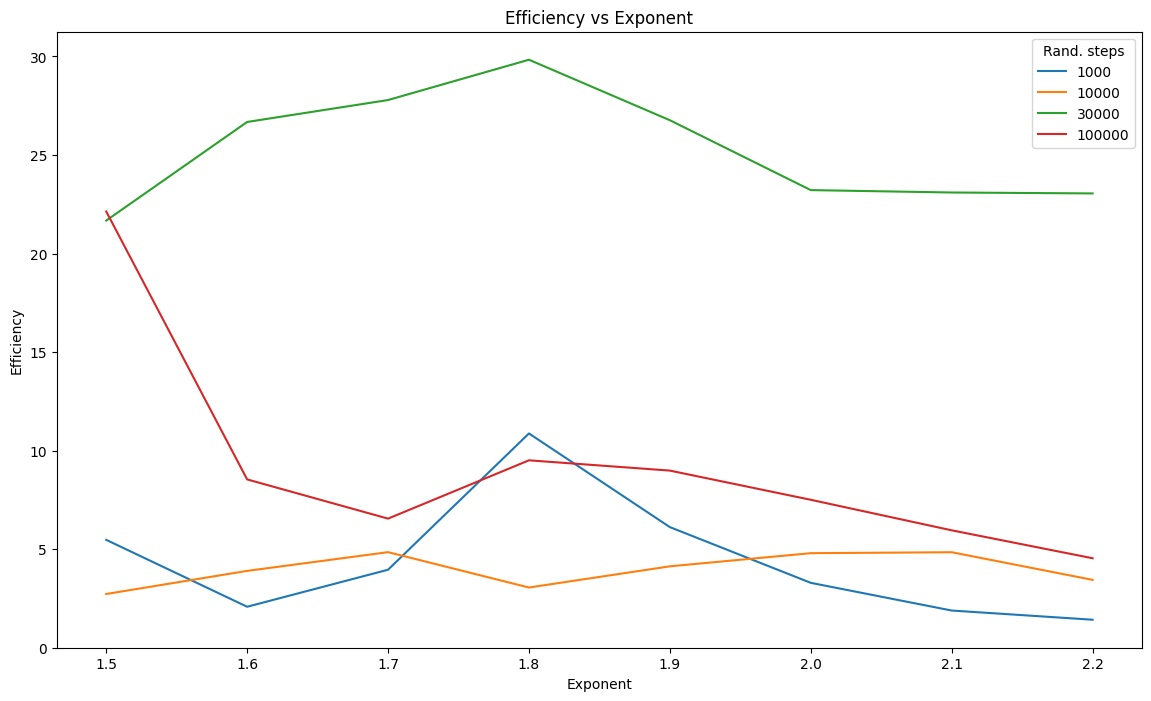

In [125]:
plt.figure("quality vs. exp", figsize=(14,8))
#plt.plot(list(avg_results.keys()), [val["quality"] for val in avg_results.values()])
for (rand_steps, efficiencies_steps) in efficiencies.items():
    plt.plot(exp_values, efficiencies_steps, label=rand_steps)
plt.legend(title="Rand. steps")
plt.title("Efficiency vs Exponent")
plt.xlabel("Exponent")
plt.ylabel("Efficiency")

plt.show()